# Task

## Details
- **Purpose:** Hiscox Data Scientist Technical Task for 2nd Stage Interview
- **Author:** Dr Jack Hall
- **Date:** 11/05/2025

# Problem Statement: Risk Prediction for Insurance Policies

This notebook demonstrates how to build a machine learning pipeline to predict the risk of a customer filing an insurance claim within one year. It covers data synthesis, exploration, preprocessing, modeling, explainability, and considerations for productionising the solution.

**Goal:** Identify the top 5% of customers most likely to file a claim and communicate an explainable model to stakeholders.

# Setup and Imports

Import all necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, f1_score
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay

# Data Synthesis

We need to synthesise a dataset of 10,000 customers with 40 features, including numerical, categorical, ordinal, missing values, and duplicates.

The target variable is the binary claim status of 0 or 1.

In [2]:
def collect_from_database(query: str) -> pd.DataFrame:
    print(f"Executing: {query}")

    # initial generation
    n_rows = 9_800
    features, labels = make_classification(
        n_samples=n_rows,
        n_features=30,
        n_informative=7,
        n_redundant=2,
        n_repeated=5,
        n_classes=2,
        class_sep=1.2,
        flip_y=0.035,
        weights=[0.85, 0.15],
        random_state=1901,
    )
    df = pd.DataFrame(features, columns=[f'numeric_{i+1}' for i in range(30)])
    df.insert(0, 'claim_status', labels)
    
    # Rename and scale
    rename_map = {
        'numeric_1': 'age',
        'numeric_2': 'height_cm',
        'numeric_3': 'weight_kg',
        'numeric_4': 'income',
        'numeric_5': 'financial_hist_1',
        'numeric_6': 'financial_hist_2',
        'numeric_7': 'financial_hist_3',
        'numeric_8': 'financial_hist_4',
        'numeric_9': 'credit_score_1',
        'numeric_10': 'credit_score_2',
        'numeric_11': 'credit_score_3',
        'numeric_12': 'insurance_hist_1',
        'numeric_13': 'insurance_hist_2',
        'numeric_14': 'insurance_hist_3',
        'numeric_15': 'insurance_hist_4',
        'numeric_16': 'insurance_hist_5',
        'numeric_17': 'insurance_hist_6',
        'numeric_18': 'insurance_hist_7',
        'numeric_19': 'insurance_hist_8',
        'numeric_20': 'insurance_hist_9',
        'numeric_21': 'insurance_hist_10',
        'numeric_22': 'insurance_hist_11',
        'numeric_23': 'insurance_hist_12',
        'numeric_24': 'insurance_hist_13',
        'numeric_25': 'insurance_hist_14',
        'numeric_26': 'insurance_hist_15',
        'numeric_27': 'insurance_hist_16',
        'numeric_28': 'insurance_hist_17',
        'numeric_29': 'insurance_hist_18',
        'numeric_30': 'insurance_hist_19'
    }
    df = df.rename(columns=rename_map)
    
    # Shift numerical columns so they are all above 0:
    for col in ['financial_hist_1', 'financial_hist_2', 'financial_hist_3', 'financial_hist_4','insurance_hist_1','insurance_hist_2','insurance_hist_3','insurance_hist_4','insurance_hist_5','insurance_hist_6','insurance_hist_7','insurance_hist_8','insurance_hist_9','insurance_hist_10','insurance_hist_11','insurance_hist_12','insurance_hist_13','insurance_hist_14','insurance_hist_15','insurance_hist_16','insurance_hist_17','insurance_hist_18','insurance_hist_19']:
        min_val = df[col].min()
        if min_val <= 0:
            # shift so the new minimum is a small positive epsilon
            df[col] = df[col] - min_val + 1e-3
    
    # Scale continuous
    scaler_ranges = {
        'age': (18,95),
        'height_cm': (140,210),
        'weight_kg': (45,125),
        'income': (0,250000),
        'credit_score_1': (0,999),
        'credit_score_2': (0,700),
        'credit_score_3': (0,710)
    }
    for col, (low, high) in scaler_ranges.items():
        df[col] = MinMaxScaler(feature_range=(low, high)).fit_transform(df[[col]]).astype(int)
    
    df['bmi'] = (df['weight_kg']/((df['height_cm']/100)**2)).astype(int)
    
    # Add categorical, ordinal, missingness
    np.random.seed(0)
    df['gender'] = np.where(df['claim_status']==0,
                             np.random.choice(['M','F'], n_rows, p=[0.54,0.46]),
                             np.random.choice(['M','F'], n_rows, p=[0.48,0.52]))
    df['marital_status'] = np.random.choice(['Single','Married','Divorced','Widowed'], n_rows,
                                            p=[0.3,0.5,0.1,0.1])
    df['education_level'] = np.random.choice(['None','Secondary','Bachelors','Masters','PhD'], n_rows,
                                             p=[0.05,0.4,0.3,0.2,0.05])
    df['occupation'] = np.random.choice(['Unemployed','Clerical','Professional','Technical','Management'],
                                        n_rows)
    df['health_status'] = np.random.randint(1,6, size=n_rows)  # 1=Excellent,5=Poor
    df['driving_record'] = np.random.randint(1,6, size=n_rows)
    df['n_dependents'] = np.random.choice([0,1,2,3,4], n_rows, p=[0.3,0.4,0.2,0.08,0.02])
    df['employment_type'] = np.random.choice(['Permanent','Contract','Temporary', None], n_rows,
                                            p=[0.6,0.2,0.1,0.1])
    
    # Insert missing values randomly
    for col in ['occupation','education_level','employment_type','family_history_3']:
        df.loc[df.sample(frac=0.1).index, col] = None
    
    # Add duplicates
    df = pd.concat([df, df.sample(200)], ignore_index=True)
    df = df.reset_index(drop=True)
    return df

## Generate Data

In [3]:
df = collect_from_database("SELECT * FROM customer_data")

Executing: SELECT * FROM customer_data


# Data Exploration and Preprocessing

## Assumptions and Justification for approach

- **Assumption 1**: I had to make simple imputation of occupation and employment_type missing values, which could introduce further of bias.
- **Justification for Approach 1**: I didn't want to remove data so I wanted to impute instead, use a quick method to start with but more complex methods could be taken later.
- **Assumptionm 2**: IQR-based outlier removal: By defining outliers as anything outside 1.5×IQR, I'm assuming the numeric features follow roughly symmetric or mildly skewed distributions.
- **Justification for Approach 2**: Outliers can bias a models performance and so to make it as reliable as possible, outliers have been removed.
- **Assumption 3**: Several categorical variables were one hot encoded implying that there’s no ordinal relationship between them.
- **Justification for Approach 3**: I think the ones I have one hot encoded, are correct.

## Initial Exploration

In [4]:
print(df.shape)

(10000, 41)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   claim_status       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   height_cm          10000 non-null  int64  
 3   weight_kg          10000 non-null  int64  
 4   income             10000 non-null  int64  
 5   financial_hist_1   10000 non-null  float64
 6   financial_hist_2   10000 non-null  float64
 7   financial_hist_3   10000 non-null  float64
 8   financial_hist_4   10000 non-null  float64
 9   credit_score_1     10000 non-null  int64  
 10  credit_score_2     10000 non-null  int64  
 11  credit_score_3     10000 non-null  int64  
 12  insurance_hist_1   10000 non-null  float64
 13  insurance_hist_2   10000 non-null  float64
 14  insurance_hist_3   10000 non-null  float64
 15  insurance_hist_4   10000 non-null  float64
 16  insurance_hist_5   1000

- We have 5 object datatypes that need dealing with / processing for modelling.
- We have missing events for several columns so these need dealing with.

Lets have a look at the ranges for the data to gain greater initial insight:

In [6]:
for col in df.columns.tolist():
    print("---------------------------------------")
    print(f"Column name: {col}, type: {df[col].dtype}, info:")
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"min: {df[col].min()}, mean: {df[col].mean()}, max: {df[col].max()}")
    else:
        print(f"nunique: {df[col].nunique()}, unique values: {df[col].unique()} ")

---------------------------------------
Column name: claim_status, type: int64, info:
min: 0, mean: 0.1619, max: 1
---------------------------------------
Column name: age, type: int64, info:
min: 18, mean: 54.2195, max: 95
---------------------------------------
Column name: height_cm, type: int64, info:
min: 140, mean: 168.9633, max: 210
---------------------------------------
Column name: weight_kg, type: int64, info:
min: 45, mean: 87.8027, max: 125
---------------------------------------
Column name: income, type: int64, info:
min: 0, mean: 124660.0923, max: 250000
---------------------------------------
Column name: financial_hist_1, type: float64, info:
min: 0.001, mean: 3.596774316249285, max: 7.790186751179507
---------------------------------------
Column name: financial_hist_2, type: float64, info:
min: 0.001, mean: 5.546787723054242, max: 12.038860778746303
---------------------------------------
Column name: financial_hist_3, type: float64, info:
min: 0.001, mean: 3.502838

- That mean income is high.
- Confirm there's missing values in education-level, occupation, employment_type
- family_history_3 can be dropped entirely.

We can already see it above but we can confirm the overall claim rate:

In [7]:
claim_rate = df['claim_status'].mean()
print(f"Overall claim rate: {claim_rate:.2%}")

Overall claim rate: 16.19%


In [8]:
print(df['claim_status'].value_counts(normalize=True))

0    0.8381
1    0.1619
Name: claim_status, dtype: float64


We can see the data is heavily class imbalanced so we will have to tackle this on the data or modelling side, I think I'll start with just class weighting.

## Data Dictionary

| Column Name           | Type    | Description / Range / Categories                                     |
|-----------------------|---------|-----------------------------------------------------------------------|
| **claim_status**      | int64   | Target: 0 = no claim, 1 = claim.  Min 0, Mean 0.1619, Max 1           |
| **age**               | int64   | Customer age in years.  Min 18, Mean 54.22, Max 95                    |
| **height_cm**         | int64   | Height in centimetres.  Min 140, Mean 168.96, Max 210                 |
| **weight_kg**         | int64   | Weight in kilograms.  Min 45, Mean 87.80, Max 125                     |
| **income**            | int64   | Annual income (£).  Min 0, Mean 124 660.09, Max 250 000               |
| **financial_hist_1**  | float64 | Financial metric 1 (shifted positive).  Min 0.001, Mean 3.60, Max 7.79 |
| **financial_hist_2**  | float64 | Financial metric 2 (shifted positive).  Min 0.001, Mean 5.55, Max 12.04 |
| **financial_hist_3**  | float64 | Financial metric 3 (shifted positive).  Min 0.001, Mean 3.50, Max 7.31 |
| **financial_hist_4**  | float64 | Financial metric 4 (shifted positive).  Min 0.001, Mean 6.74, Max 14.12 |
| **credit_score_1**    | int64   | Credit score source 1.  Min 0, Mean 459.73, Max 999                   |
| **credit_score_2**    | int64   | Credit score source 2.  Min 0, Mean 381.46, Max 700                   |
| **credit_score_3**    | int64   | Credit score source 3.  Min 0, Mean 369.93, Max 710                   |
| **insurance_hist_1**  | float64 | Insurance history metric 1.  Min 0.001, Mean 9.17, Max 18.39           |
| **insurance_hist_2**  | float64 | Insurance history metric 2.  Min 0.001, Mean 3.68, Max 7.54            |
| **insurance_hist_3**  | float64 | Insurance history metric 3.  Min 0.001, Mean 7.03, Max 14.26           |
| **insurance_hist_4**  | float64 | Insurance history metric 4.  Min 0.001, Mean 7.17, Max 13.14           |
| **insurance_hist_5**  | float64 | Insurance history metric 5.  Min 0.001, Mean 4.01, Max 8.41            |
| **insurance_hist_6**  | float64 | Insurance history metric 6.  Min 0.001, Mean 5.55, Max 12.04           |
| **insurance_hist_7**  | float64 | Insurance history metric 7.  Min 0.001, Mean 3.83, Max 7.78            |
| **insurance_hist_8**  | float64 | Insurance history metric 8.  Min 0.001, Mean 3.43, Max 7.15            |
| **insurance_hist_9**  | float64 | Insurance history metric 9.  Min 0.001, Mean 3.77, Max 7.51            |
| **insurance_hist_10** | float64 | Insurance history metric 10. Min 0.001, Mean 3.75, Max 7.49            |
| **insurance_hist_11** | float64 | Insurance history metric 11. Min 0.001, Mean 4.28, Max 8.57            |
| **insurance_hist_12** | float64 | Insurance history metric 12. Min 0.001, Mean 3.99, Max 7.53            |
| **insurance_hist_13** | float64 | Insurance history metric 13. Min 0.001, Mean 3.91, Max 7.77           |
| **insurance_hist_14** | float64 | Insurance history metric 14. Min 0.001, Mean 3.67, Max 7.69           |
| **insurance_hist_15** | float64 | Insurance history metric 15. Min 0.001, Mean 9.30, Max 15.59          |
| **insurance_hist_16** | float64 | Insurance history metric 16. Min 0.001, Mean 3.68, Max 8.24           |
| **insurance_hist_17** | float64 | Insurance history metric 17. Min 0.001, Mean 3.70, Max 7.15           |
| **insurance_hist_18** | float64 | Insurance history metric 18. Min 0.001, Mean 7.08, Max 11.68          |
| **insurance_hist_19** | float64 | Insurance history metric 19. Min 0.001, Mean 3.68, Max 6.88           |
| **bmi**               | int64   | Body Mass Index.  Min 14, Mean 30.54, Max 51                        |
| **gender**            | object  | Categorical: ‘M’ or ‘F’                                              |
| **marital_status**    | object  | Categorical: Single, Married, Divorced, Widowed                      |
| **education_level**   | object  | Categorical: None, Secondary, Bachelors, Masters, PhD                |
| **occupation**        | object  | Categorical: Unemployed, Clerical, Professional, Technical, Management |
| **health_status**     | int64   | Ordinal 1–5 (1=Excellent, 5=Poor).  Min 1, Mean 3.02, Max 5           |
| **driving_record**    | int64   | Ordinal 1–5 (1=Best, 5=Worst).  Min 1, Mean 2.998, Max 5              |
| **n_dependents**      | int64   | Number of dependents.  Min 0, Mean 1.13, Max 4                       |
| **employment_type**   | object  | Categorical: Permanent, Contract, Temporary (10% missing)           |
| **family_history_3**  | float64 | Originally had missing-only values (10% missing).                    |


## Data Cleaning

### Check for duplicates

In [9]:
print("Duplicated rows:", len(df[df.duplicated()]))

Duplicated rows: 200


Need to remove duplicated data

In [10]:
df = df[~df.duplicated()]

In [11]:
print(df.shape)

(9800, 41)


### Redundant Columns

This one has no information so we can remove this straight away.

In [12]:
df = df.drop(columns=["family_history_3"])

### Missingness

Columns with nulls:

In [13]:
for col in df.columns.tolist():
    if df[col].isnull().sum() > 0: print(col)

education_level
occupation
employment_type


#### education_level

In [14]:
print(df["education_level"].value_counts(dropna=False))
print(df["education_level"].value_counts(normalize=True, dropna=False))

Secondary    3533
Bachelors    2707
Masters      1726
None          980
PhD           444
None          410
Name: education_level, dtype: int64
Secondary    0.360510
Bachelors    0.276224
Masters      0.176122
None         0.100000
PhD          0.045306
None         0.041837
Name: education_level, dtype: float64


Hmm so 10% are missing, but they could be any of those so we need to impute really.

Maybe for this instead we can change this to an ordinal variable where the hierarchy comes form the education level achieved and from their we can impute the median.

In [15]:
# Define the ordinal mapping
education_mapping = {'None': 0, 'Secondary': 1, 'Bachelors': 2, 'Masters': 3, 'PhD': 4}

# Map the education levels to ordinal values
df['education_level'] = df['education_level'].map(education_mapping)

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
df['education_level'] = imputer.fit_transform(df[['education_level']])

# Make the values int
df['education_level'] = df['education_level'].astype('int')

In [16]:
print(df['education_level'].value_counts())

2    3687
1    3533
3    1726
4     444
0     410
Name: education_level, dtype: int64


#### occupation

In [17]:
print(df["occupation"].value_counts(dropna=False))

Technical       1805
Clerical        1773
Professional    1761
Management      1759
Unemployed      1722
None             980
Name: occupation, dtype: int64


Again quite a large amount of missing data here, it needs a proper imputation method and analysis.

For simplicity here, we'll just set it to technical.

In [18]:
df.loc[df["occupation"].isnull(), "occupation"] = "Technical"

In [19]:
print(df["occupation"].value_counts(dropna=False))

Technical       2785
Clerical        1773
Professional    1761
Management      1759
Unemployed      1722
Name: occupation, dtype: int64


#### employment_type

In [20]:
print(df["employment_type"].value_counts(dropna=False))
print("Missing:", df["employment_type"].isnull().sum())

Permanent    5309
None         1880
Contract     1772
Temporary     839
Name: employment_type, dtype: int64
Missing: 1880


Again a significant amount missing, needs a proper imputation process to avoid removing the data. Again here, we will assume that they are in permanent employment.

In [21]:
df.loc[df["employment_type"].isnull(), "employment_type"] = "Permanent"

In [22]:
print(df["employment_type"].value_counts(dropna=False))

Permanent    7189
Contract     1772
Temporary     839
Name: employment_type, dtype: int64


### Datatypes

Object datatypes to fix/deal with for modelling:

In [23]:
for col in df.columns.tolist():
    if df[col].dtype == 'object': print(col)

gender
marital_status
occupation
employment_type


#### gender

In [24]:
print(df['gender'].value_counts())

M    5271
F    4529
Name: gender, dtype: int64


We only have two values for this so we can set this as binary.

In [25]:
# Define the mapping
gender_mapping = {'M': 1, 'F': 0}

# Apply mapping to convert gender values to integers
df['gender'] = df['gender'].map(gender_mapping).astype(int)

#### marital_status

In [26]:
print(df['marital_status'].value_counts())

Married     4903
Single      2938
Widowed      986
Divorced     973
Name: marital_status, dtype: int64


In [27]:
df['marital_status'] = df['marital_status'].astype('category')

In [28]:
print(df['marital_status'].value_counts())
print(df['marital_status'].dtype)

Married     4903
Single      2938
Widowed      986
Divorced     973
Name: marital_status, dtype: int64
category


#### occupation

In [29]:
print(df['occupation'].value_counts())

Technical       2785
Clerical        1773
Professional    1761
Management      1759
Unemployed      1722
Name: occupation, dtype: int64


In [30]:
df['occupation'] = df['occupation'].astype('category')

In [31]:
print(df['occupation'].value_counts())
print(df['occupation'].dtype)

Technical       2785
Clerical        1773
Professional    1761
Management      1759
Unemployed      1722
Name: occupation, dtype: int64
category


#### employment_type

In [32]:
print(df['employment_type'].value_counts())

Permanent    7189
Contract     1772
Temporary     839
Name: employment_type, dtype: int64


In [33]:
df['employment_type'] = df['employment_type'].astype('category')

In [34]:
print(df['employment_type'].value_counts())
print(df['employment_type'].dtype)

Permanent    7189
Contract     1772
Temporary     839
Name: employment_type, dtype: int64
category


### Dataset following Cleaning

In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 0 to 9799
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   claim_status       9800 non-null   int64   
 1   age                9800 non-null   int64   
 2   height_cm          9800 non-null   int64   
 3   weight_kg          9800 non-null   int64   
 4   income             9800 non-null   int64   
 5   financial_hist_1   9800 non-null   float64 
 6   financial_hist_2   9800 non-null   float64 
 7   financial_hist_3   9800 non-null   float64 
 8   financial_hist_4   9800 non-null   float64 
 9   credit_score_1     9800 non-null   int64   
 10  credit_score_2     9800 non-null   int64   
 11  credit_score_3     9800 non-null   int64   
 12  insurance_hist_1   9800 non-null   float64 
 13  insurance_hist_2   9800 non-null   float64 
 14  insurance_hist_3   9800 non-null   float64 
 15  insurance_hist_4   9800 non-null   float64 
 16  insura

## Exploratory Data Analysis

### Univariate Distributions

Identify numeric and categorical columns

In [36]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()

#### Numerical

Numeric Summary Statistics

In [37]:
numeric_summary = df[numeric_cols].describe().T
print(numeric_summary)

                    count           mean           std      min  \
claim_status       9800.0       0.162143      0.368601    0.000   
age                9800.0      54.218061     10.486313   18.000   
height_cm          9800.0     168.987041      9.077005  140.000   
weight_kg          9800.0      87.813673     10.877378   45.000   
income             9800.0  124664.116939  32248.246939    0.000   
financial_hist_1   9800.0       3.596640      0.998807    0.001   
financial_hist_2   9800.0       5.552789      1.880828    0.001   
financial_hist_3   9800.0       3.501991      1.012163    0.001   
financial_hist_4   9800.0       6.736099      1.922670    0.001   
credit_score_1     9800.0     460.231837    156.089716    0.000   
credit_score_2     9800.0     381.631531     92.232063    0.000   
credit_score_3     9800.0     370.008061     92.882698    0.000   
insurance_hist_1   9800.0       9.171028      2.372103    0.001   
insurance_hist_2   9800.0       3.676163      1.001824    0.00

Histograms & Boxplots for Numeric Features

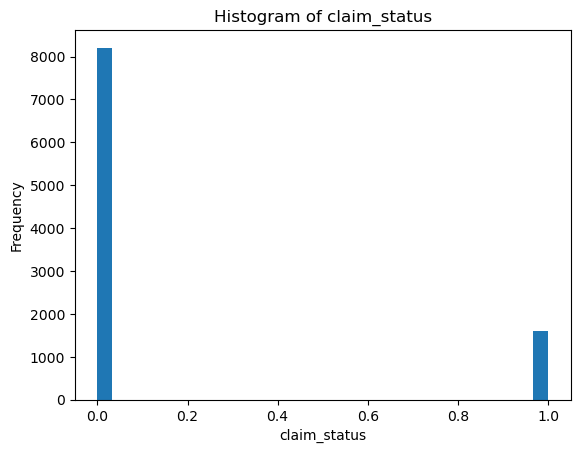

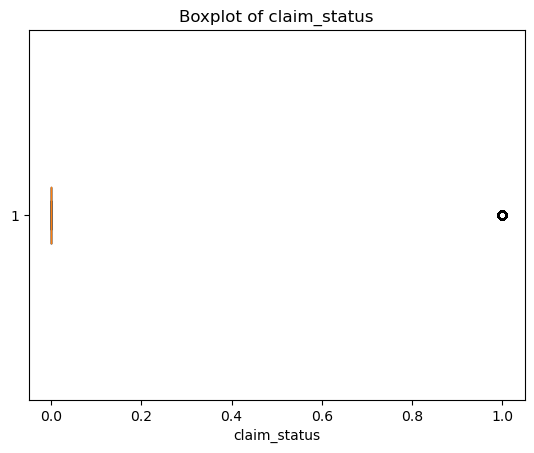

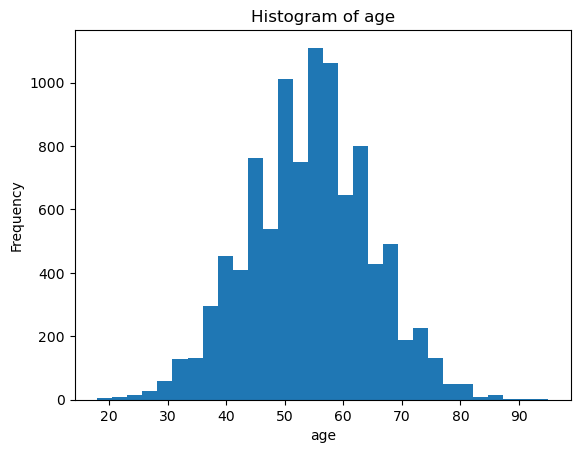

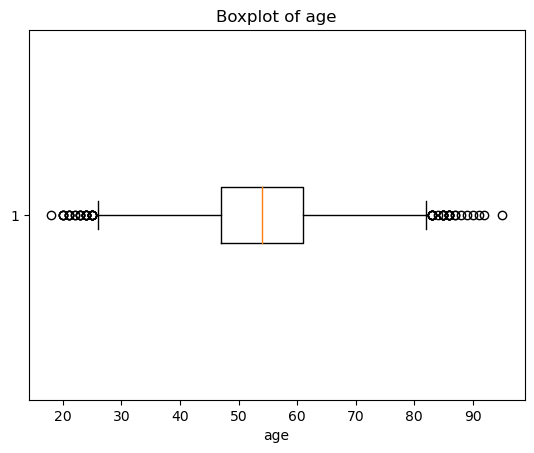

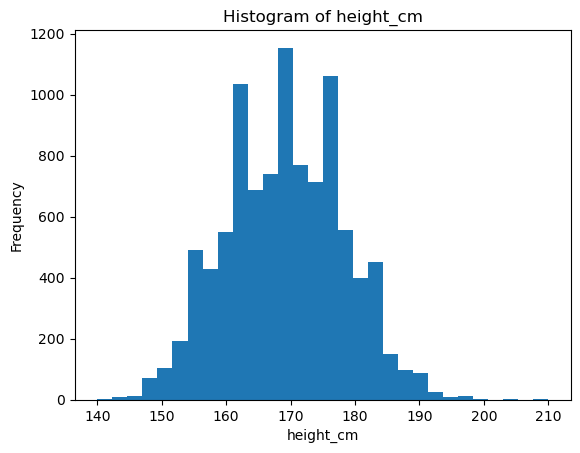

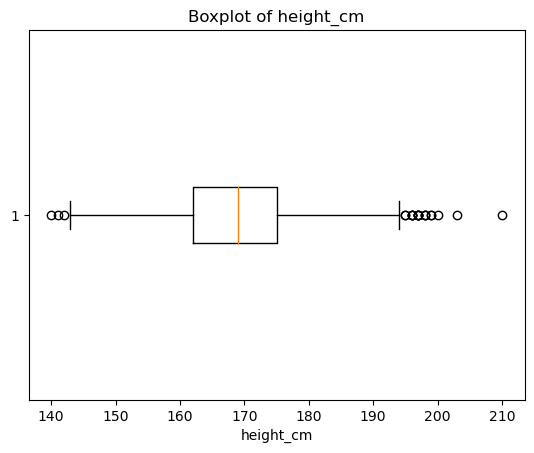

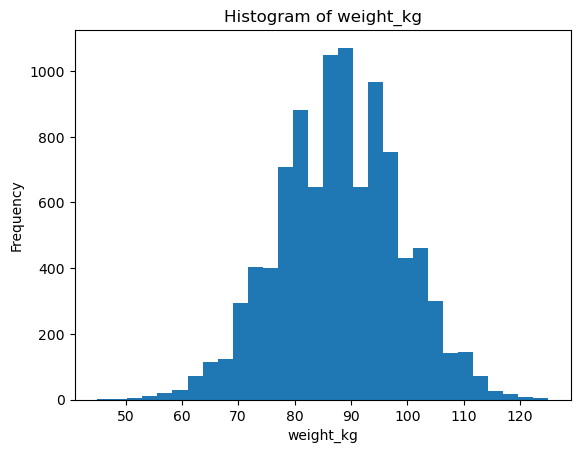

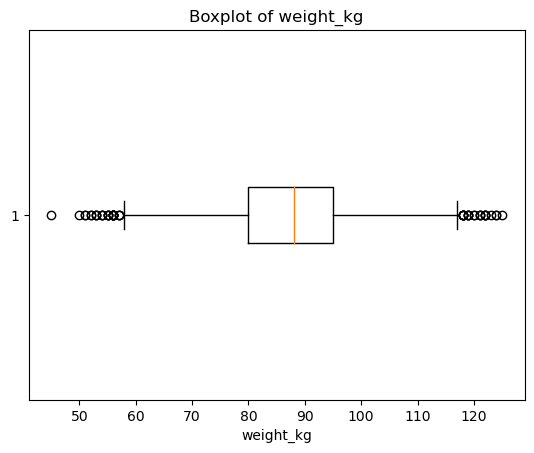

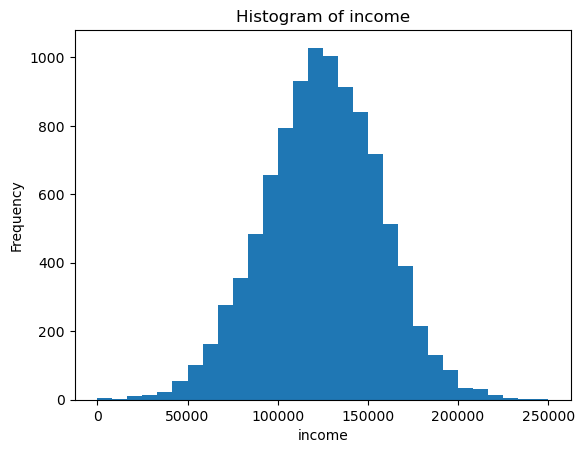

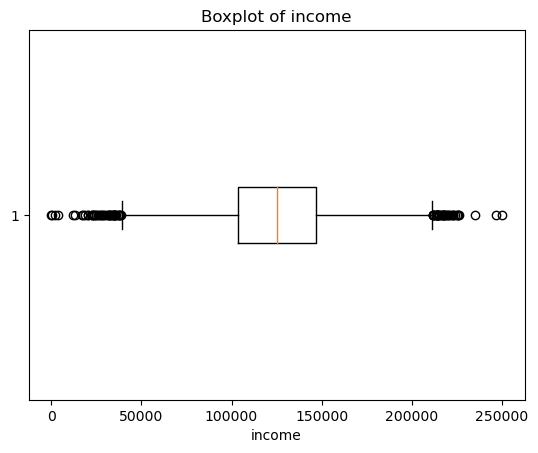

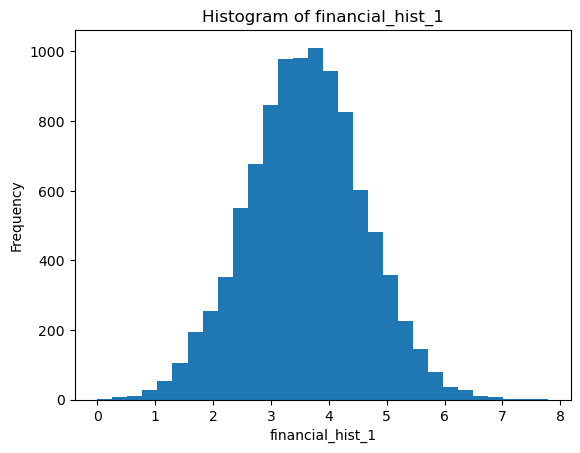

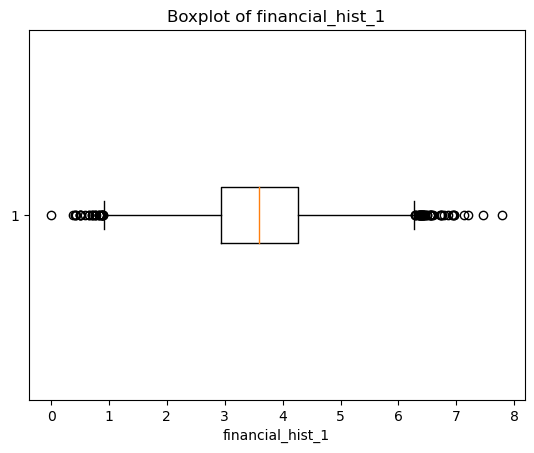

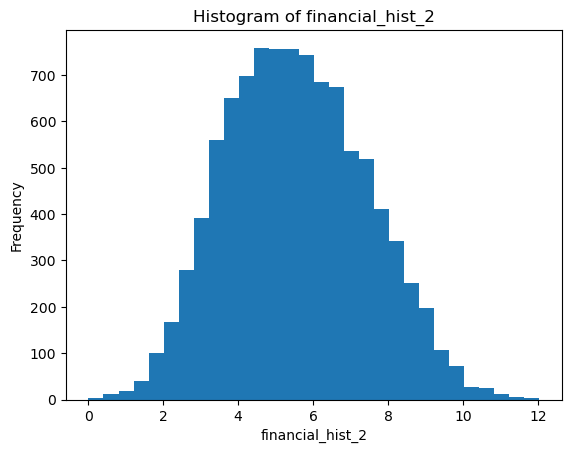

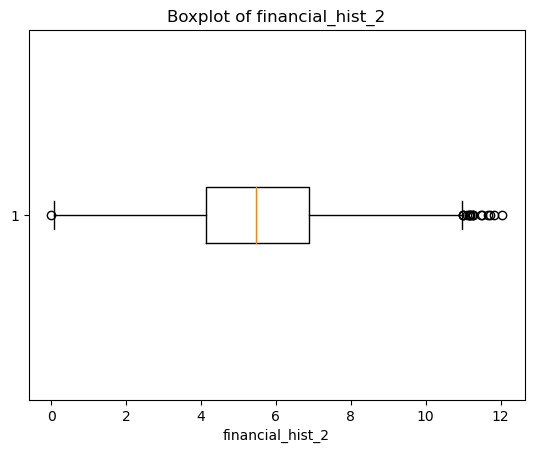

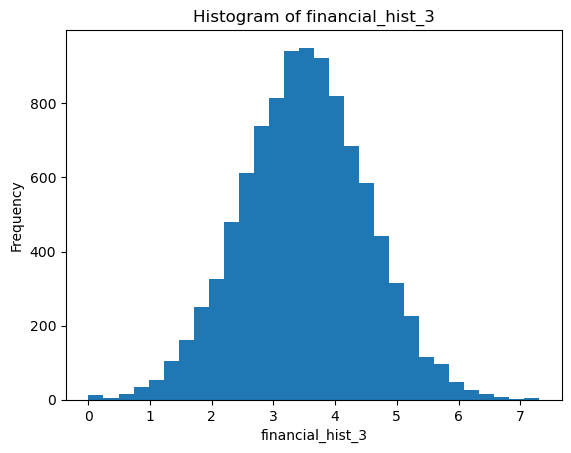

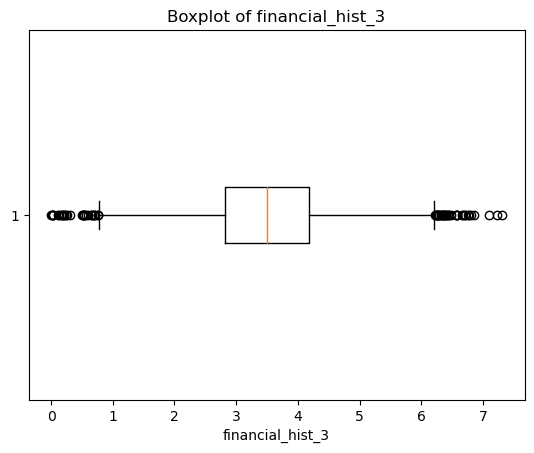

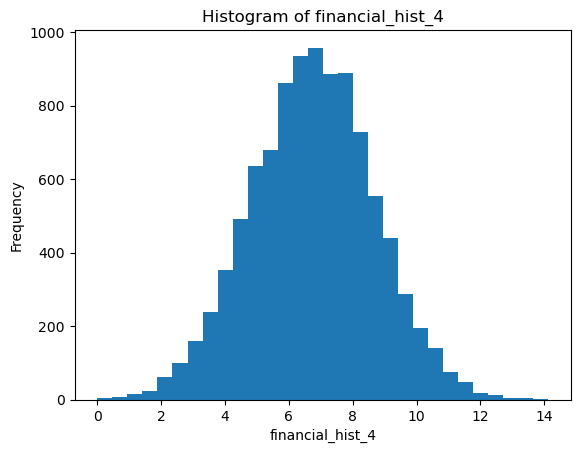

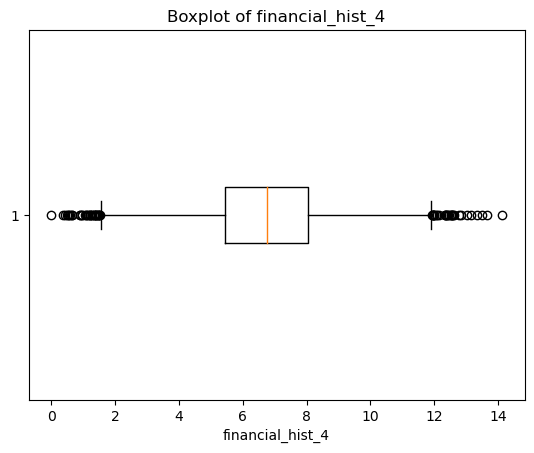

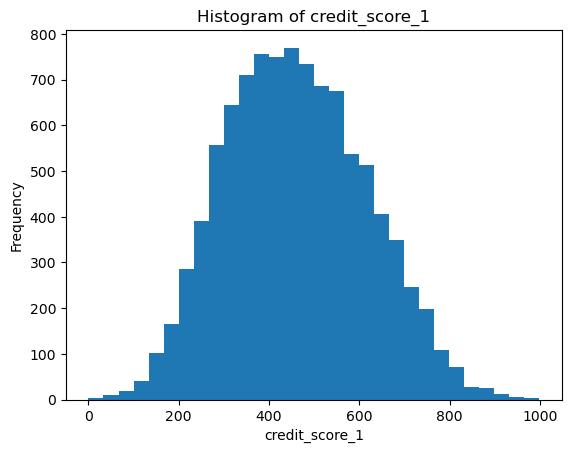

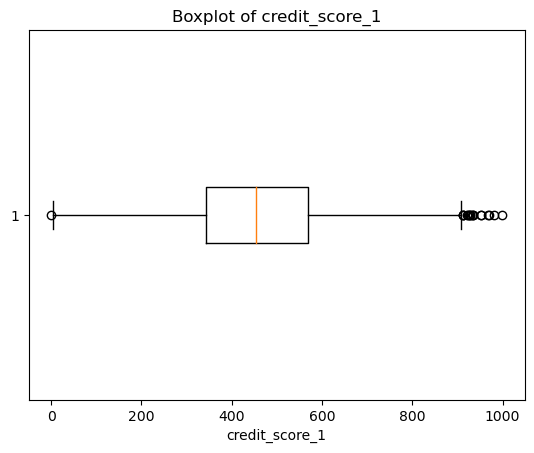

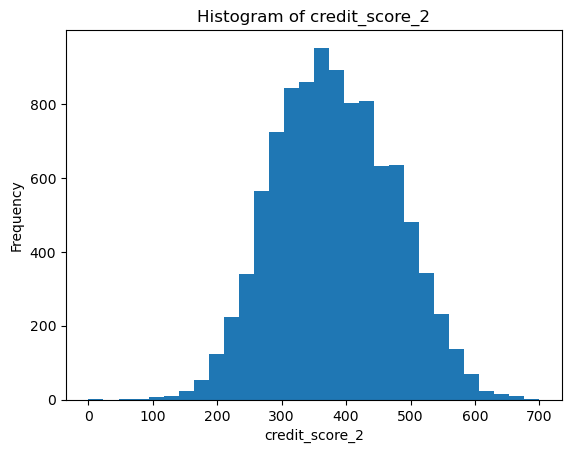

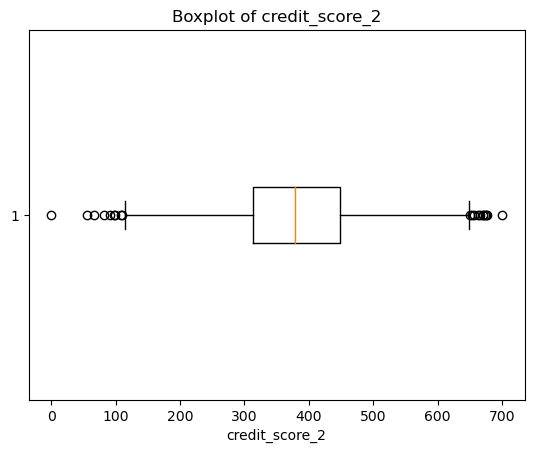

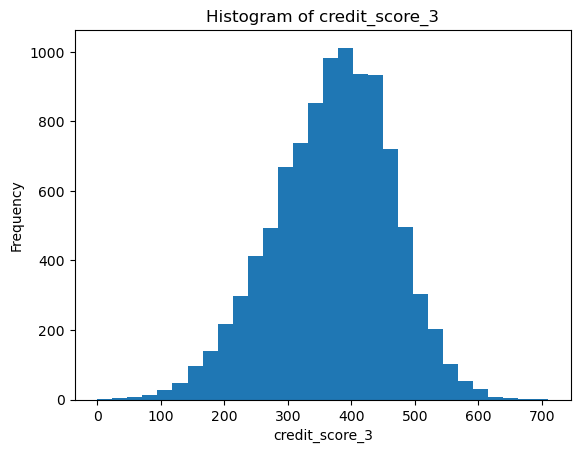

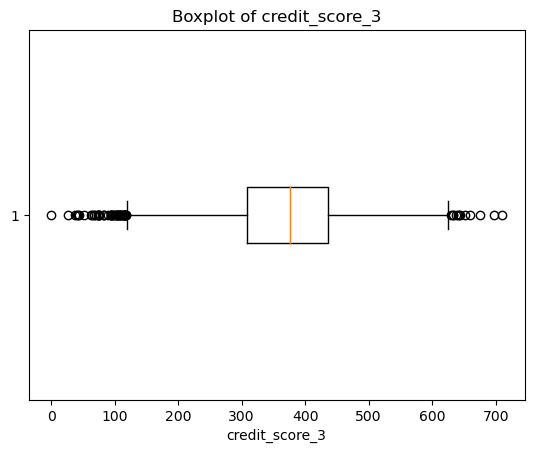

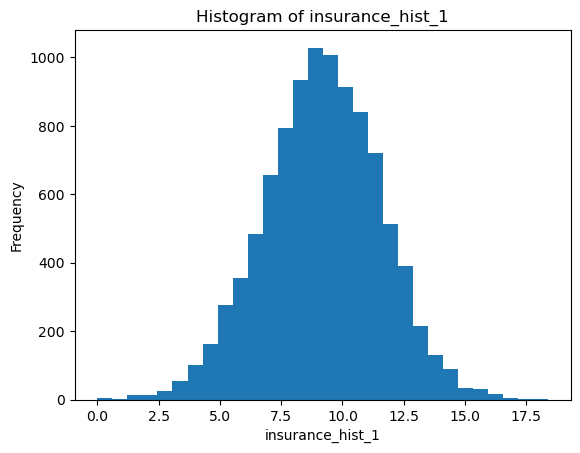

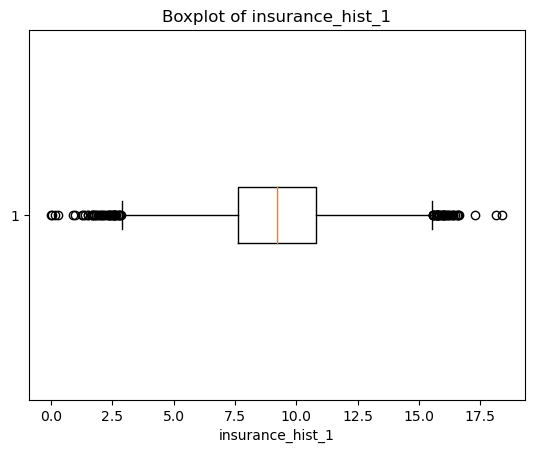

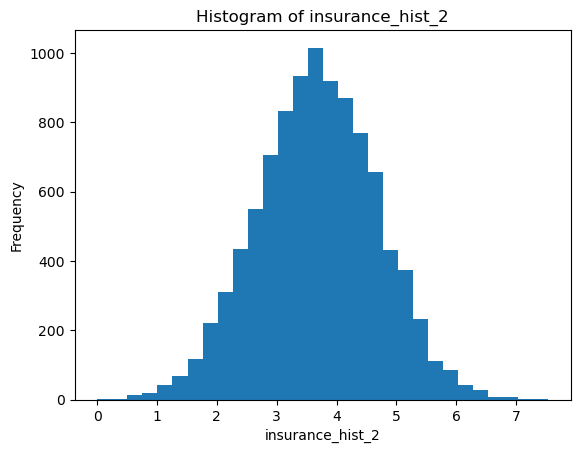

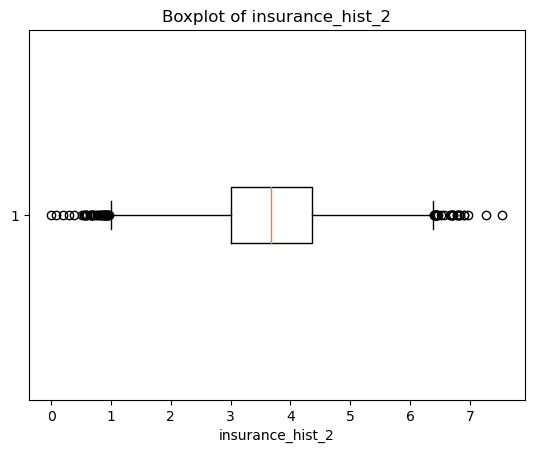

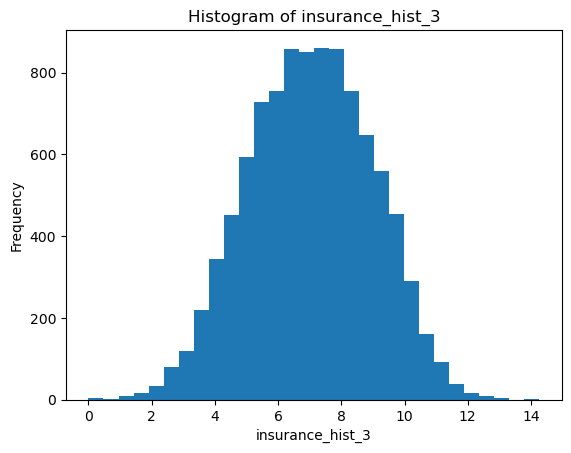

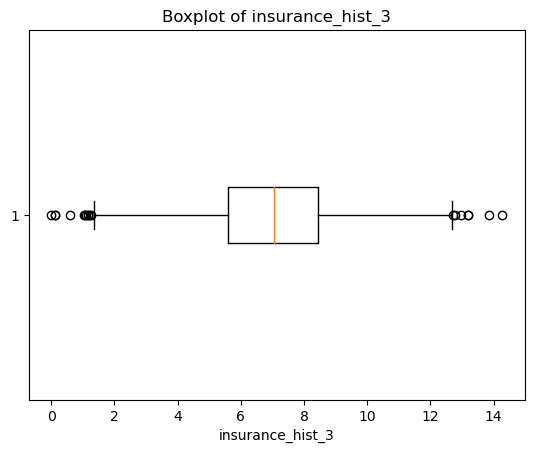

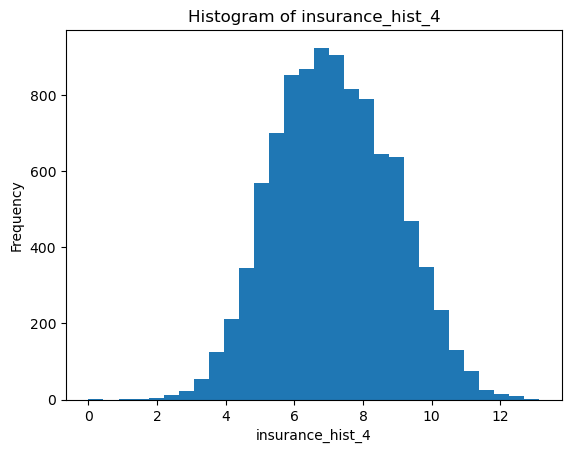

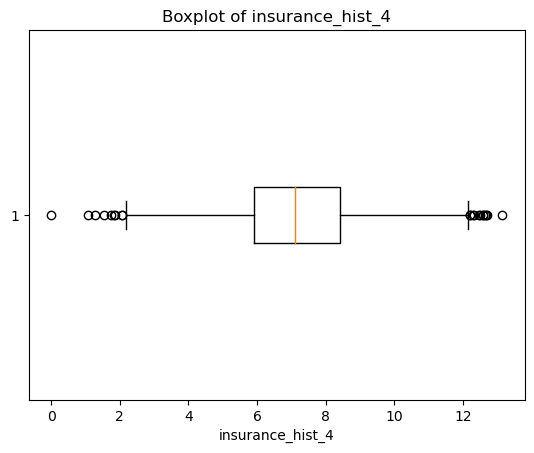

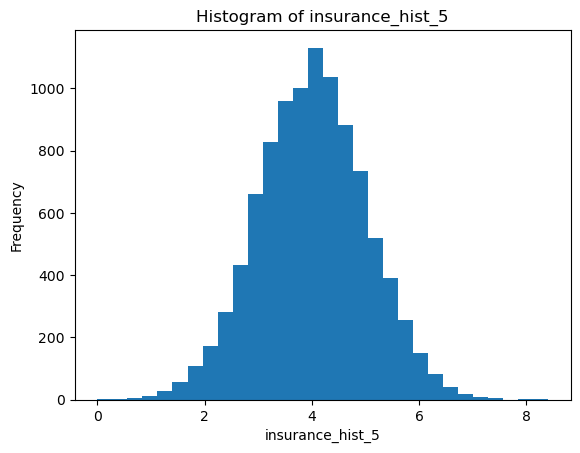

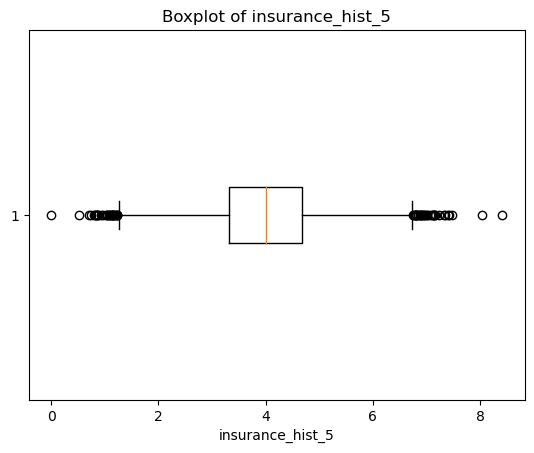

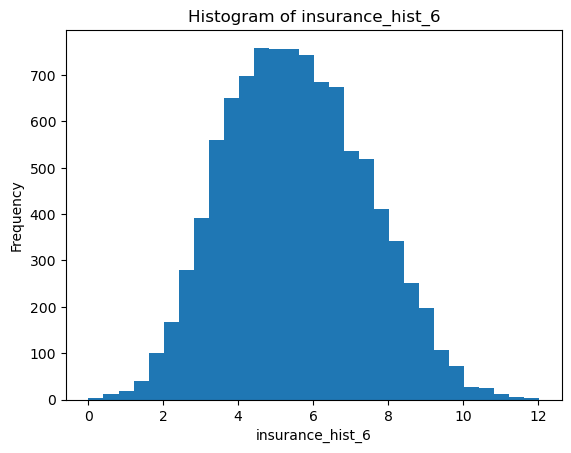

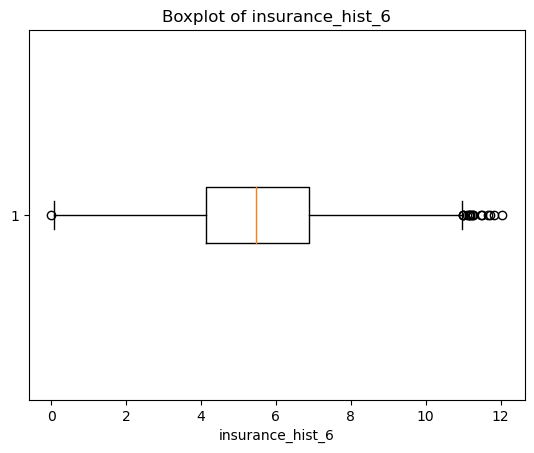

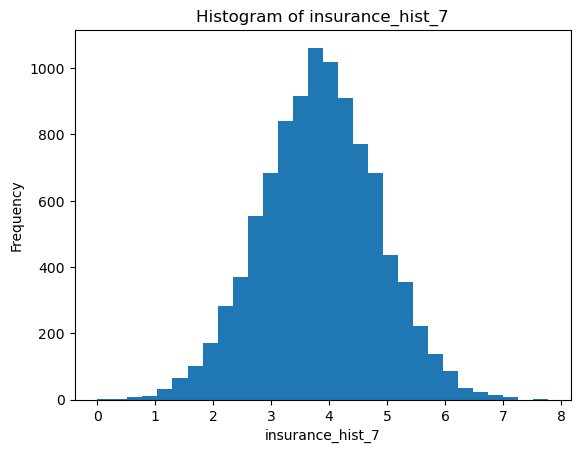

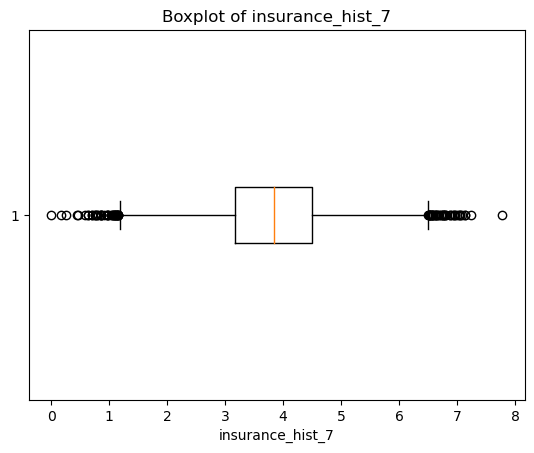

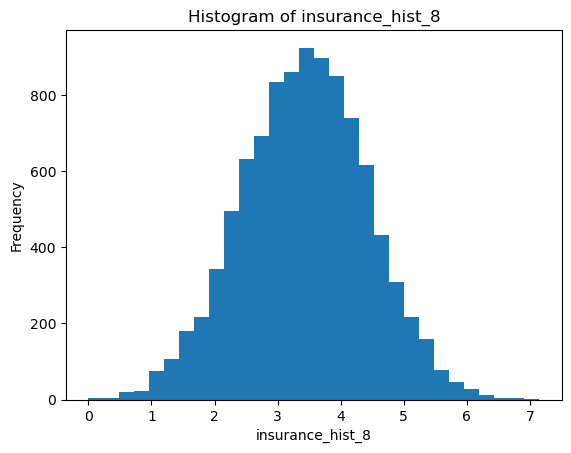

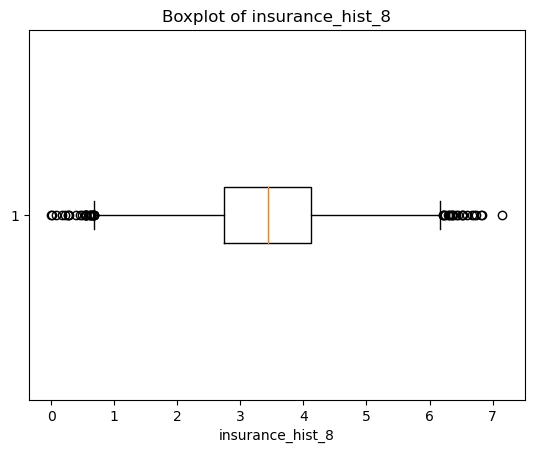

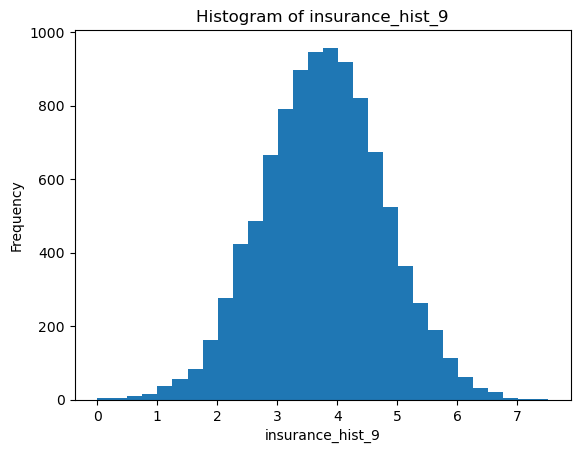

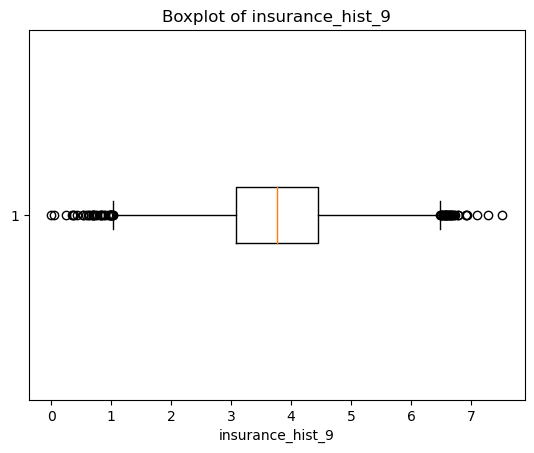

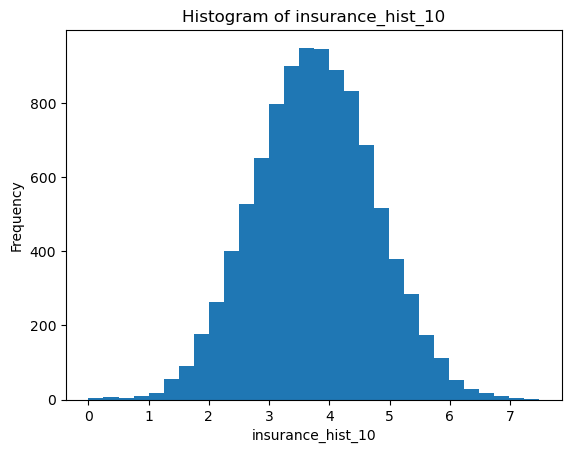

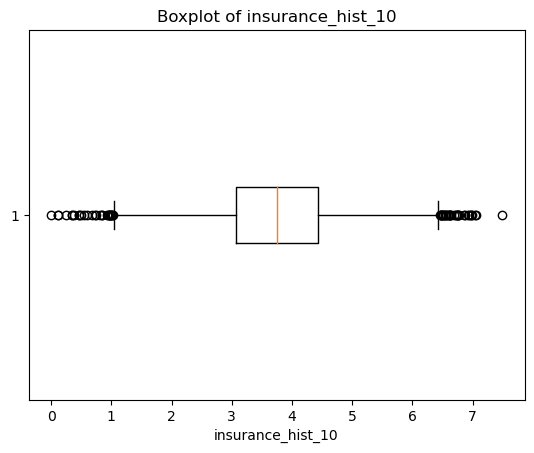

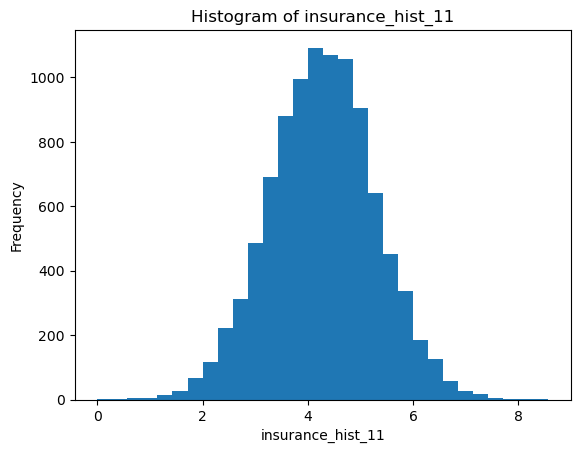

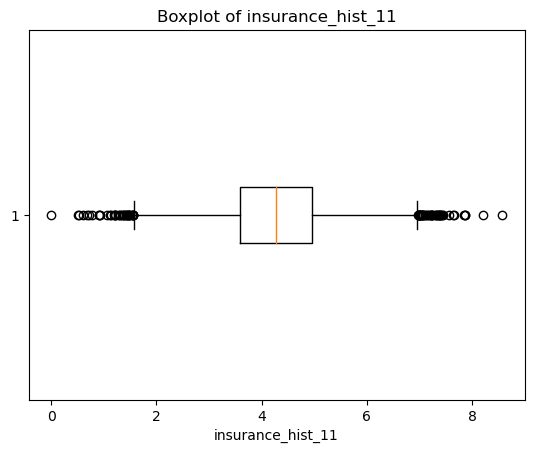

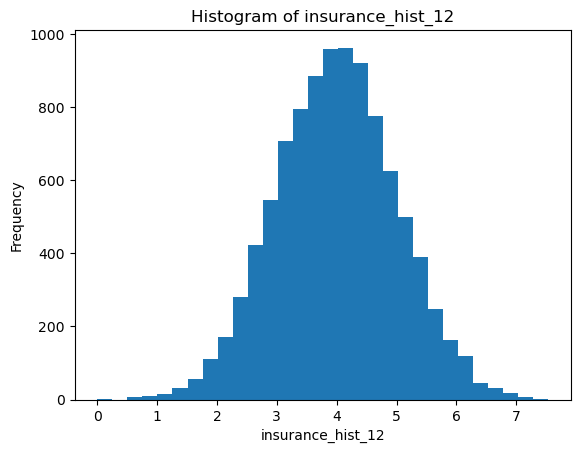

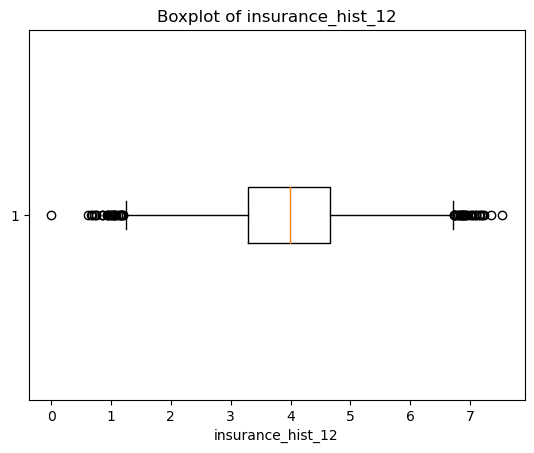

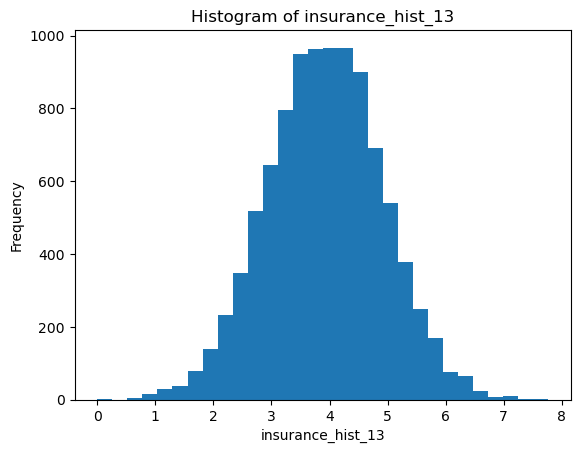

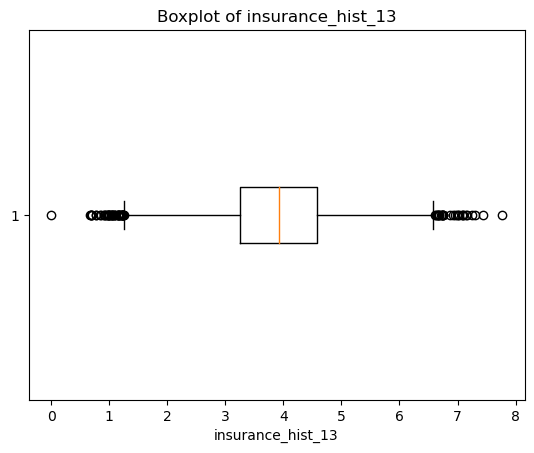

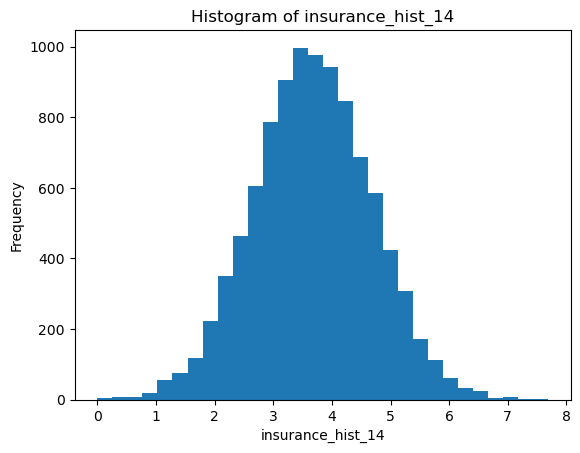

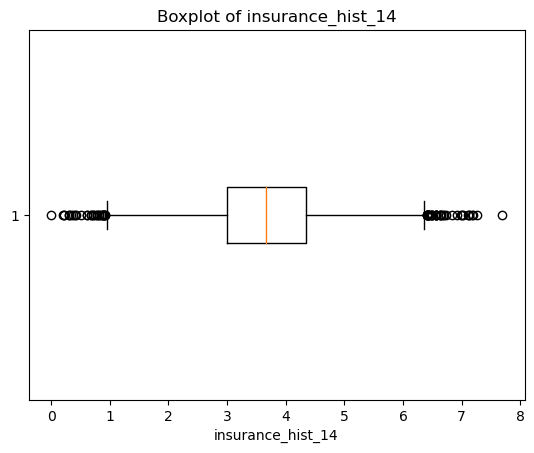

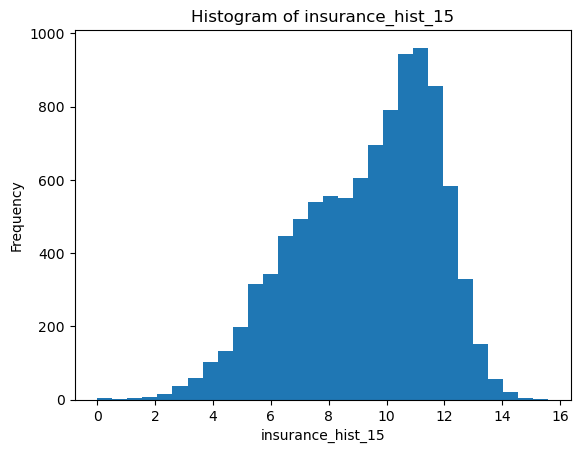

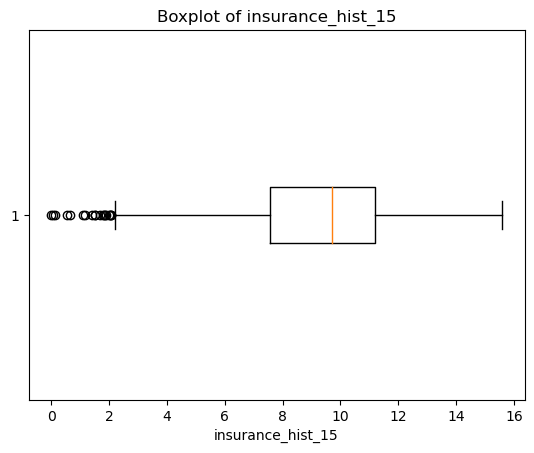

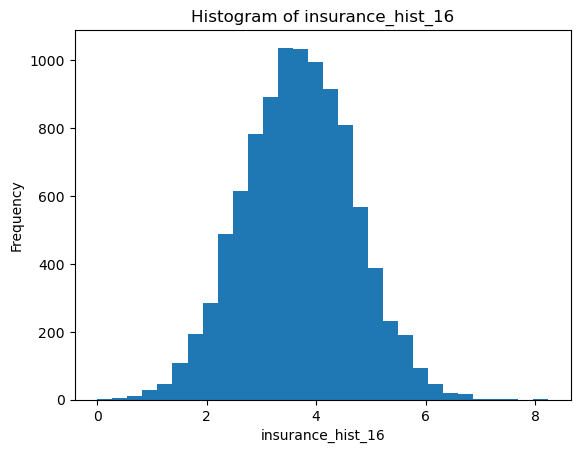

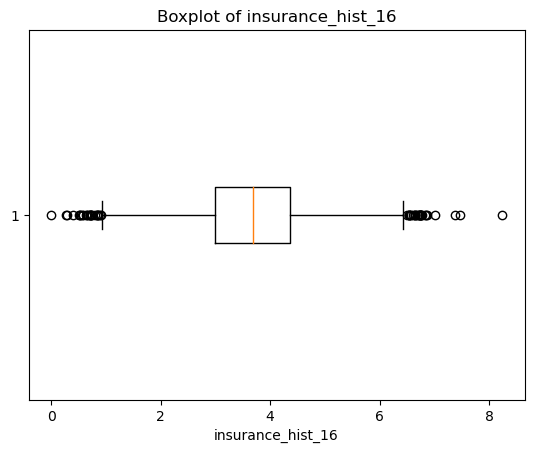

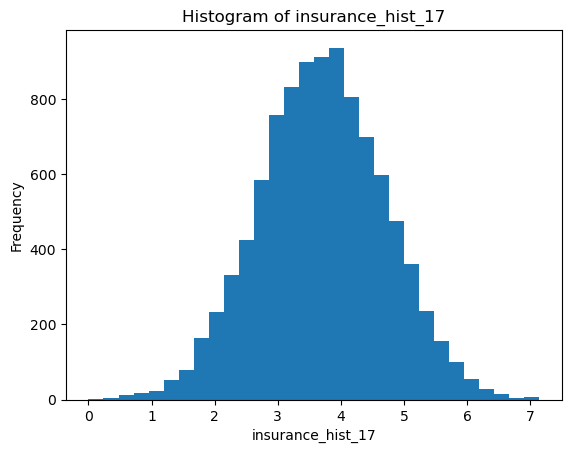

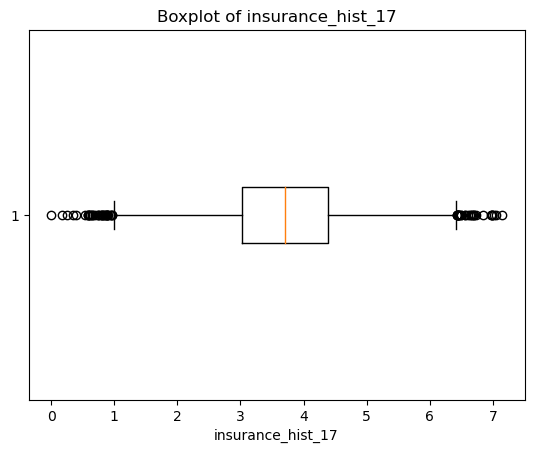

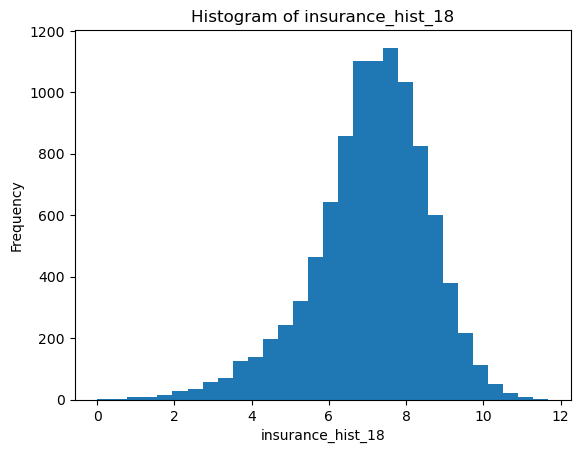

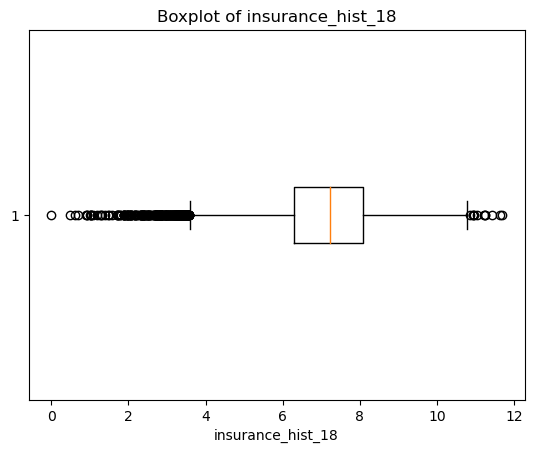

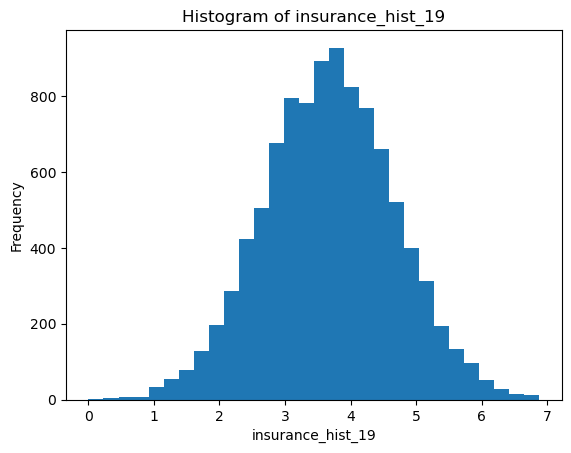

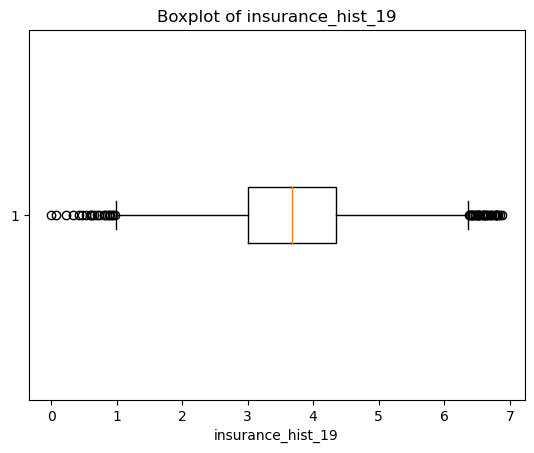

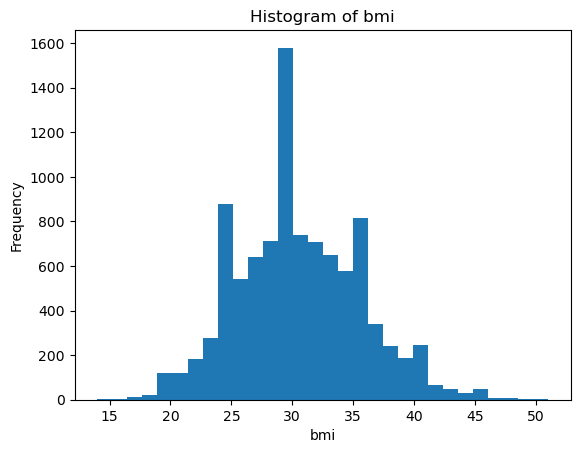

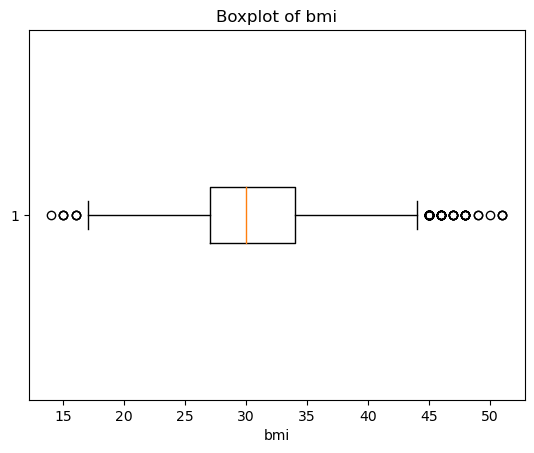

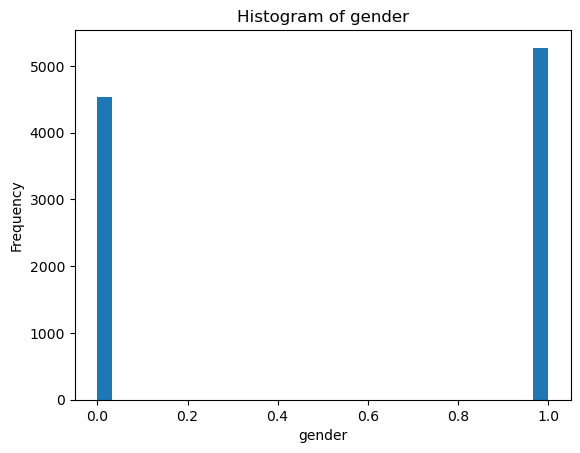

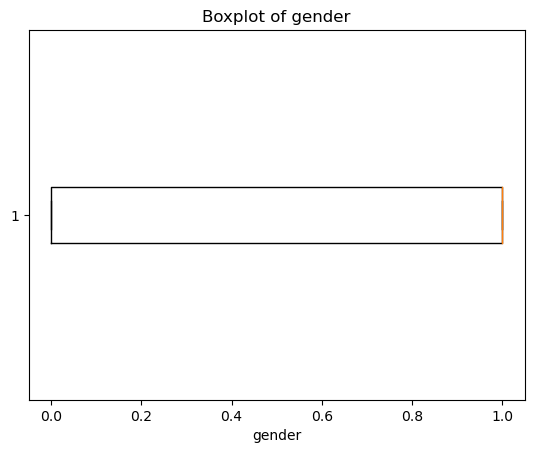

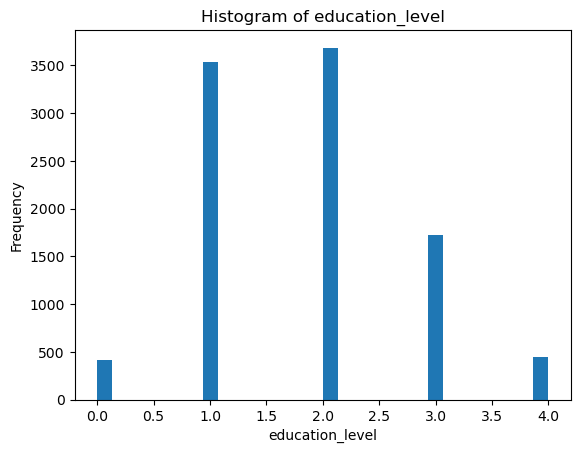

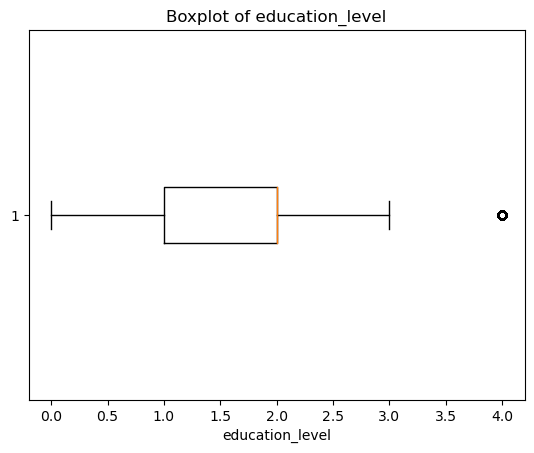

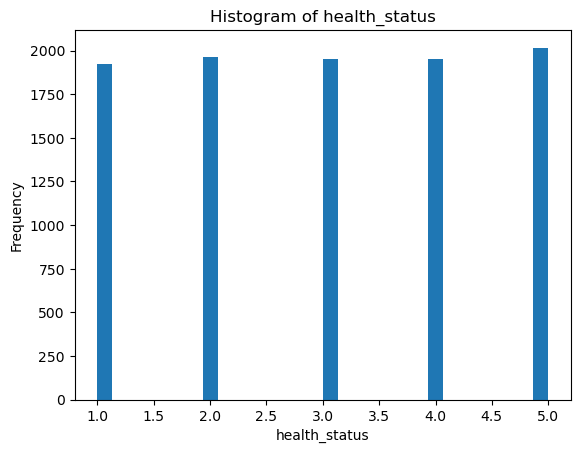

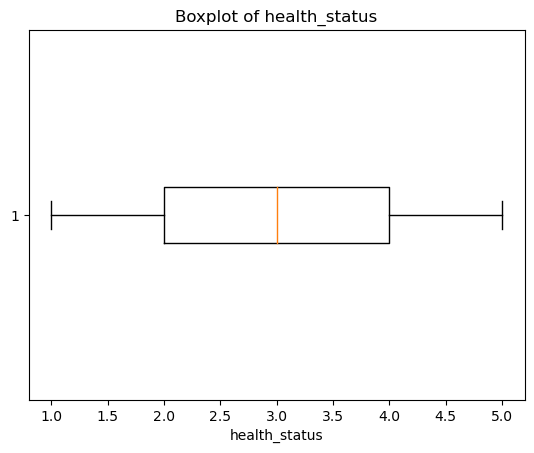

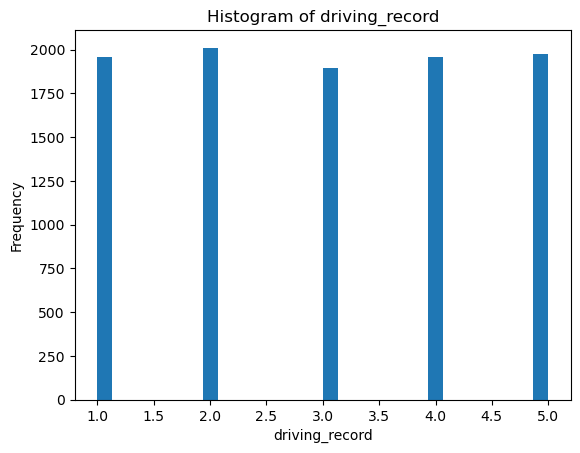

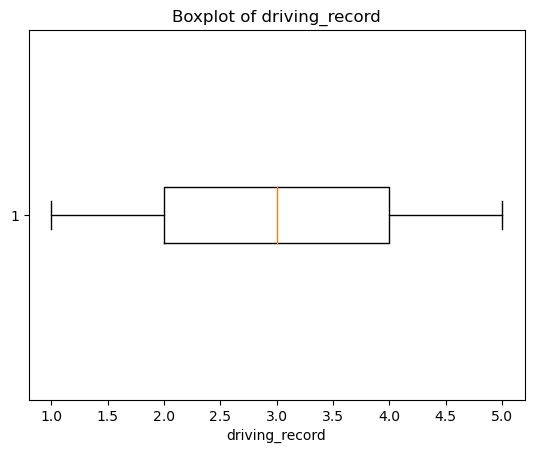

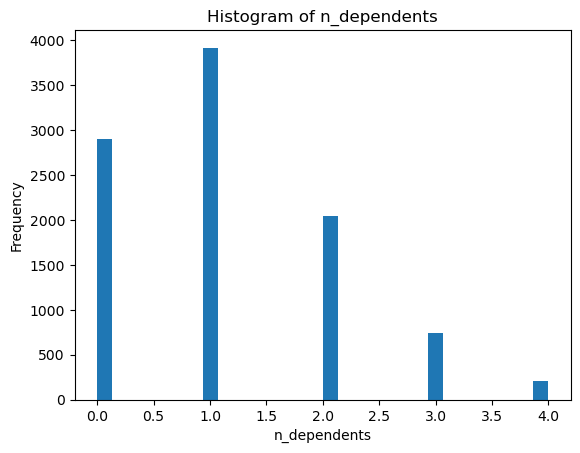

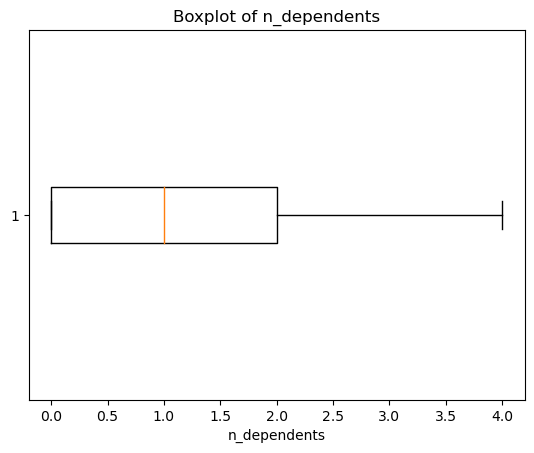

In [38]:
for col in numeric_cols:
    # Histogram
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    
    # Boxplot
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()


#### Categorical

Categorical Value Counts

In [39]:
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False))


Value counts for marital_status:
Married     4903
Single      2938
Widowed      986
Divorced     973
Name: marital_status, dtype: int64

Value counts for occupation:
Technical       2785
Clerical        1773
Professional    1761
Management      1759
Unemployed      1722
Name: occupation, dtype: int64

Value counts for employment_type:
Permanent    7189
Contract     1772
Temporary     839
Name: employment_type, dtype: int64


### Outlier Assessment

In [40]:
numeric_cols.remove("claim_status")

In [41]:
outlier_info = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    n_outliers = mask.sum()
    pct_outliers = 100 * n_outliers / len(df)
    
    outlier_info.append({
        "Column": col,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outliers Count": n_outliers,
        "Outliers (%)": pct_outliers
    })

outlier_df = pd.DataFrame(outlier_info)

In [42]:
print(outlier_df)

               Column   Lower Bound    Upper Bound  Outliers Count  \
0                 age     26.000000      82.000000              59   
1           height_cm    142.500000     194.500000              22   
2           weight_kg     57.500000     117.500000              51   
3              income  39206.000000  211218.000000              85   
4    financial_hist_1      0.914662       6.283707              74   
5    financial_hist_2      0.048930      10.965772              18   
6    financial_hist_3      0.774465       6.221235              68   
7    financial_hist_4      1.545453      11.926244              63   
8      credit_score_1      2.500000     910.500000              18   
9      credit_score_2    113.000000     649.000000              20   
10     credit_score_3    118.500000     626.500000              63   
11   insurance_hist_1      2.884999      15.537675              85   
12   insurance_hist_2      0.971482       6.396429              66   
13   insurance_hist_

We do have a few outliers <1% per feature. education_level is the highest at 4.5%.

In [43]:
# Build a dict of (lower, upper) bounds per column:
bounds = {}
for entry in outlier_info:
    col = entry['Column']
    bounds[col] = (entry['Lower Bound'], entry['Upper Bound'])

# Build a boolean mask that is True only for “inliers” on every numeric column
mask = pd.Series(True, index=df.index)
for col in numeric_cols:
    lower, upper = bounds[col]
    mask &= df[col].between(lower, upper)

# Apply it to get your cleaned DataFrame:
df_clean = df[mask].reset_index(drop=True)

print(f"Dropped {len(df) - len(df_clean)} rows; remaining={len(df_clean)} rows.")

Dropped 1871 rows; remaining=7929 rows.


In [44]:
del df
df = df_clean
del df_clean

## Feature Selection and Engineering

### Feature Engineering

Sadly, no time.

### Correlations

In [45]:
df_encoded = pd.get_dummies(df, drop_first=True)  # Convert categorical features into numerical format

In [46]:
numeric_features = df_encoded.select_dtypes(include=[np.number]).dropna()

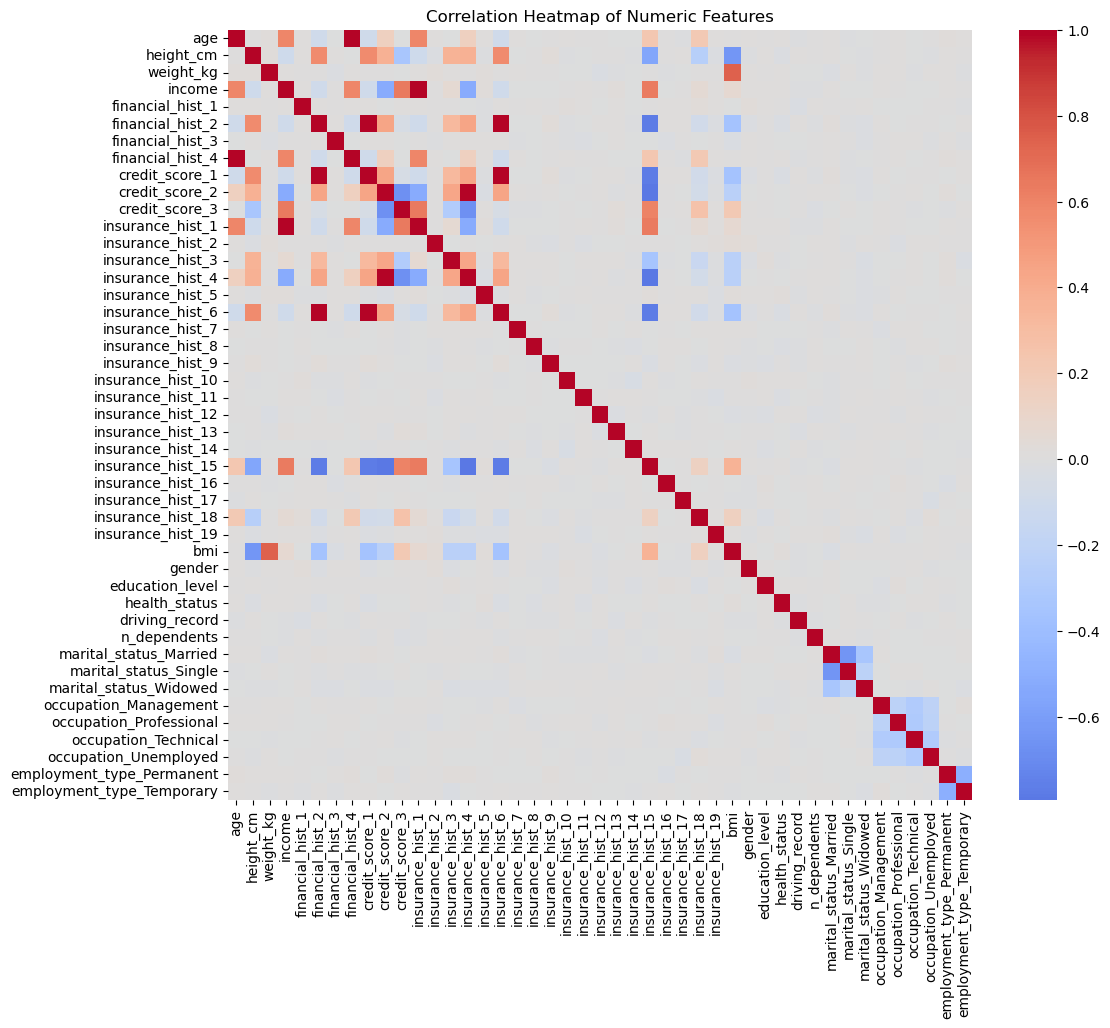

In [47]:
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.drop(columns=["claim_status"]).corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

There's a few high (positive/negative) correlation pairs in there.

In [48]:
# Compute correlation matrix
corr_matrix = numeric_features.drop(columns=["claim_status"]).corr()

# Mask upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(mask)

# Stack and filter |corr| > 0.5
high_corr_pairs = (
    upper_corr
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
)
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.5]

In [49]:
print(high_corr_pairs.sort_values(by=["Correlation"],ascending=False))

                      Feature1                   Feature2  Correlation
220           financial_hist_2           insurance_hist_6     1.000000
136                     income           insurance_hist_1     1.000000
212           financial_hist_2             credit_score_1     0.999998
331             credit_score_1           insurance_hist_6     0.999998
364             credit_score_2           insurance_hist_4     0.999995
6                          age           financial_hist_4     0.999591
114                  weight_kg                        bmi     0.741369
395             credit_score_3           insurance_hist_1     0.639112
135                     income             credit_score_3     0.639112
442           insurance_hist_1          insurance_hist_15     0.635762
150                     income          insurance_hist_15     0.635762
409             credit_score_3          insurance_hist_15     0.605385
290           financial_hist_4           insurance_hist_1     0.587420
132   

- 100% correlations are very concerning and won't be very good in a linear model.
- Other than that we have have manhy other high correlation pairs.

### LASSO Feature Selection

In [50]:
feature_cols = df_encoded.columns.tolist()

# Remove target
feature_cols.remove("claim_status")

In [51]:
X = df_encoded[feature_cols]
y = df_encoded["claim_status"]

model = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, n_jobs=-1, random_state=42)
)
model.fit(X, y)
coefs = pd.Series(model.named_steps['lassocv'].coef_, index=feature_cols)
selected = coefs[coefs.abs() > 5e-2].index.tolist()


In [52]:
print(coefs[coefs.abs() > 5e-2].sort_values(ascending=False))

credit_score_3       0.093680
height_cm            0.079834
age                 -0.091976
insurance_hist_18   -0.148464
dtype: float64


A good initial hint to possible useful features. Interesting only 4 remain.

## Preprocessing Pipeline

Impute missing values, encode categoricals, scale numericals.

In [53]:
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   claim_status               7929 non-null   int64  
 1   age                        7929 non-null   int64  
 2   height_cm                  7929 non-null   int64  
 3   weight_kg                  7929 non-null   int64  
 4   income                     7929 non-null   int64  
 5   financial_hist_1           7929 non-null   float64
 6   financial_hist_2           7929 non-null   float64
 7   financial_hist_3           7929 non-null   float64
 8   financial_hist_4           7929 non-null   float64
 9   credit_score_1             7929 non-null   int64  
 10  credit_score_2             7929 non-null   int64  
 11  credit_score_3             7929 non-null   int64  
 12  insurance_hist_1           7929 non-null   float64
 13  insurance_hist_2           7929 non-null   float

Define feature lists

In [54]:
num_cols = df_encoded[selected].select_dtypes(include=['int64','float64','uint8']).columns.tolist()
cat_cols = df_encoded[selected].select_dtypes(include=['category']).columns.tolist()

Preprocessors

In [55]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

Train-test split

Just remove protected characteristics like gender and age.

In [56]:
X = df_encoded[selected]

In [57]:
# X = df_encoded.drop(columns=['claim_status','gender', 'age'])
y = df_encoded['claim_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Modelling

## Development

Fit a pipeline with preprocessor and classifier. Compare Logistic Regression and RandomForest.

### Baseline

Logistic Regression

In [58]:
pipeline_lr = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
pipeline_lr.fit(X_train, y_train)
# pred_proba_lr = pipeline_lr.predict_proba(X_test)[:,1]
# auc_rf = roc_auc_score(y_test, pred_proba_lr)
# print(f"Logistic Regression AUC: {auc_rf:.3f}")

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'height_cm',
                                                   'credit_score_3',
                                                   'insurance_hist_18']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                

In [59]:
# Predictions
pred_train = pipeline_lr.predict(X_train)
pred_test = pipeline_lr.predict(X_test)

# Probabilities for AUC
pred_proba_lr_train = pipeline_lr.predict_proba(X_train)[:, 1]
pred_proba_lr_test = pipeline_lr.predict_proba(X_test)[:, 1]

# Compute AUC-ROC scores
auc_lr_train = roc_auc_score(y_train, pred_proba_lr_train)
auc_lr_test = roc_auc_score(y_test, pred_proba_lr_test)

# Compute F1-scores
f1_lr_train = f1_score(y_train, pred_train)
f1_lr_test = f1_score(y_test, pred_test)

# Print results
print(f"Logistic Regression AUC (Train): {auc_lr_train:.3f}")
print(f"Logistic Regression AUC (Test): {auc_lr_test:.3f}")
print(f"Logistic Regression F1-score (Train): {f1_lr_train:.3f}")
print(f"Logistic Regression F1-score (Test): {f1_lr_test:.3f}")


Logistic Regression AUC (Train): 0.918
Logistic Regression AUC (Test): 0.943
Logistic Regression F1-score (Train): 0.680
Logistic Regression F1-score (Test): 0.714


Assess how well predicted probabilities align with actual claim rates as its important that “60%” really means 60% of customers with that score go on to claim.

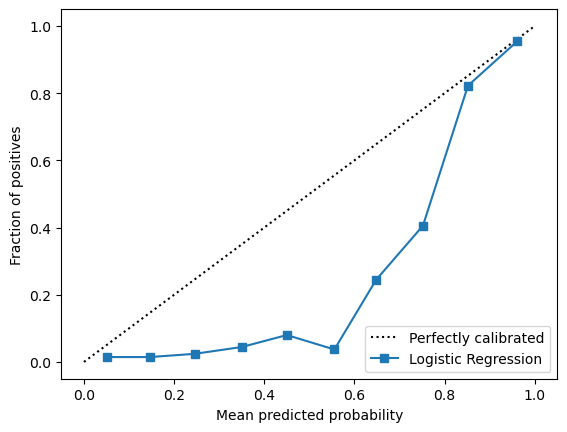

In [60]:
model = pipeline_lr
X_eval, y_eval = X_test, y_test

# Get predicted probabilities for the positive class
probs = model.predict_proba(X_eval)[:, 1]

# Create and plot the calibration display in one go
disp = CalibrationDisplay.from_predictions(
    y_true=y_eval,
    y_prob=probs,
    n_bins=10,
    strategy='uniform',
    name='Logistic Regression'
)

Very poorly calibrated

### Advanced Technique

In [61]:
# Compute class weight ratio
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

In [62]:
pipeline_xgb = Pipeline([
    ('preproc', preprocessor),
    ('clf', XGBClassifier(n_estimators=50, random_state=42, scale_pos_weight=scale_pos_weight))
])
pipeline_xgb.fit(X_train, y_train)
# pred_proba_rf = pipeline_xgb.predict_proba(X_test)[:,1]
# auc_rf = roc_auc_score(y_test, pred_proba_rf)
# print(f"Random Forest AUC: {auc_rf:.3f}")

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'height_cm',
                                                   'credit_score_3',
                                                   'insurance_hist_18']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                

In [63]:
# Predictions
pred_train = pipeline_xgb.predict(X_train)
pred_test = pipeline_xgb.predict(X_test)

# Probabilities for AUC
pred_proba_xgb_train = pipeline_xgb.predict_proba(X_train)[:, 1]
pred_proba_xgb_test = pipeline_xgb.predict_proba(X_test)[:, 1]

# Compute AUC-ROC scores
auc_xgb_train = roc_auc_score(y_train, pred_proba_xgb_train)
auc_xgb_test = roc_auc_score(y_test, pred_proba_xgb_test)

# Compute F1-scores
f1_xgb_train = f1_score(y_train, pred_train)
f1_xgb_test = f1_score(y_test, pred_test)

# Print results
print(f"Logistic Regression AUC (Train): {auc_xgb_train:.3f}")
print(f"Logistic Regression AUC (Test): {auc_xgb_test:.3f}")
print(f"Logistic Regression F1-score (Train): {f1_xgb_train:.3f}")
print(f"Logistic Regression F1-score (Test): {f1_xgb_test:.3f}")

Logistic Regression AUC (Train): 0.999
Logistic Regression AUC (Test): 0.953
Logistic Regression F1-score (Train): 0.958
Logistic Regression F1-score (Test): 0.852


Overfitting a bit but still a reasonable improvement above the logistic regression.

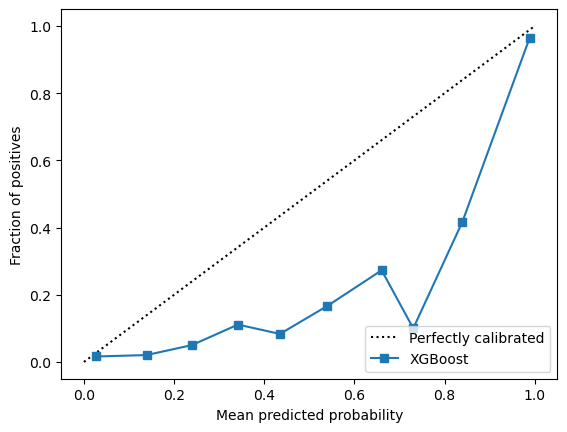

In [64]:
model = pipeline_xgb
X_eval, y_eval = X_test, y_test

# Get predicted probabilities for the positive class
probs = model.predict_proba(X_eval)[:, 1]

# Create and plot the calibration display in one go
disp = CalibrationDisplay.from_predictions(
    y_true=y_eval,
    y_prob=probs,
    n_bins=10,
    strategy='uniform',
    name='XGBoost'
)

Apply Platt scaling via CalibratedClassifierCV to get better-probability estimates.

In [65]:
# Instantiate the calibrated model
calibrated_xgb = CalibratedClassifierCV(
    base_estimator=pipeline_xgb, 
    method='sigmoid', 
    cv=5
)

In [66]:
# Fit on the training data
calibrated_xgb.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('preproc',
                                                       ColumnTransformer(transformers=[('num',
                                                                                        Pipeline(steps=[('imputer',
                                                                                                         SimpleImputer(strategy='median')),
                                                                                                        ('scaler',
                                                                                                         MinMaxScaler())]),
                                                                                        ['age',
                                                                                         'height_cm',
                                                                                         'credit_score_3',
                                       

In [67]:
# Predictions
pred_train = calibrated_xgb.predict(X_train)
pred_test = calibrated_xgb.predict(X_test)

# Probabilities for AUC
pred_proba_xgb_cal_train = calibrated_xgb.predict_proba(X_train)[:, 1]
pred_proba_xgb_cal_test = calibrated_xgb.predict_proba(X_test)[:, 1]

# Compute AUC-ROC scores
auc_xgb_cal_train = roc_auc_score(y_train, pred_proba_xgb_cal_train)
auc_xgb_cal_test = roc_auc_score(y_test, pred_proba_xgb_cal_test)

# Compute F1-scores
f1_xgb_cal_train = f1_score(y_train, pred_train)
f1_xgb_cal_test = f1_score(y_test, pred_test)

# Print results
print(f"Logistic Regression AUC (Train): {auc_xgb_cal_train:.3f}")
print(f"Logistic Regression AUC (Test): {auc_xgb_cal_test:.3f}")
print(f"Logistic Regression F1-score (Train): {f1_xgb_cal_train:.3f}")
print(f"Logistic Regression F1-score (Test): {f1_xgb_cal_test:.3f}")

Logistic Regression AUC (Train): 0.999
Logistic Regression AUC (Test): 0.957
Logistic Regression F1-score (Train): 0.948
Logistic Regression F1-score (Test): 0.878


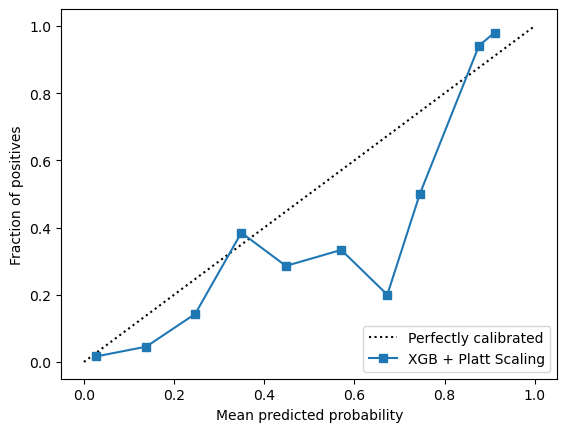

In [68]:
# Plot a calibration curve post-calibration
disp_cal = CalibrationDisplay.from_predictions(
    y_true=y_test,
    y_prob=pred_proba_xgb_cal_test,
    n_bins=10,
    strategy='uniform',
    name='XGB + Platt Scaling'
)

- Improved for predicted values below <0.4 but still problematic between 0.4 and 0.7.
- This is partly good though, it means we are better informed on low risk customers, which is where we are evaluating.
- On the other hand some of the probabilities in the 0.4-0.7 range will be underpriced.
- To guard against mispricing, we recommend tiered risk buckets rather than relying on exact probabilities, combined with a conservative premium buffer.
- We’ll continue to refine calibration with isotonic methods and real-world claim feedback upon deployment, and institute automated drift monitoring so we can recalibrate frequently without manual intervention.

## Evaluation

Plot ROC curves and select threshold for top 5% risk.

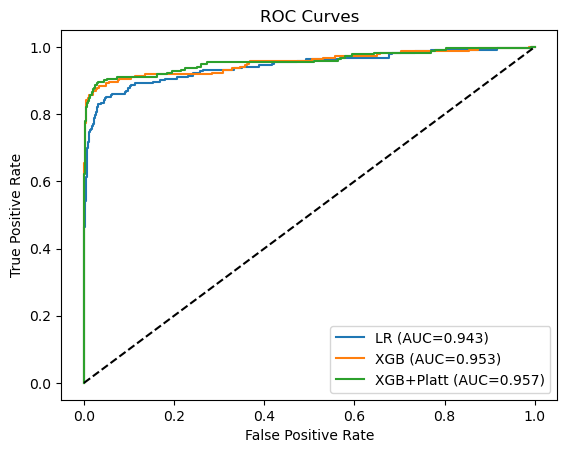

In [69]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pred_proba_lr_test)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, pred_proba_xgb_test)
fpr_xgb_cal, tpr_xgb_cal, thresholds_xgb_cal = roc_curve(y_test, pred_proba_xgb_cal_test)
plt.figure();
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={auc_lr_test:.3f})');
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={auc_xgb_test:.3f})');
plt.plot(fpr_xgb_cal, tpr_xgb_cal, label=f'XGB+Platt (AUC={auc_xgb_cal_test:.3f})');
plt.plot([0,1],[0,1],'k--');
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.legend(); plt.title('ROC Curves');

Determine threshold for top 5%:
**Acceptance threshold**: If you only want to accept the 95 % lowest-risk customers, you’d compute the 95th percentile of {p^i}{p^​i​}—call it tt—and only sell to those with p^i≤tp^​i​≤t.

In [70]:
thresh = np.percentile(pred_proba_xgb_cal_test, 95)
print(f"Threshold for top 5% risk: {thresh:.3f}")

Threshold for top 5% risk: 0.912


## Explainability

### Feature Importance

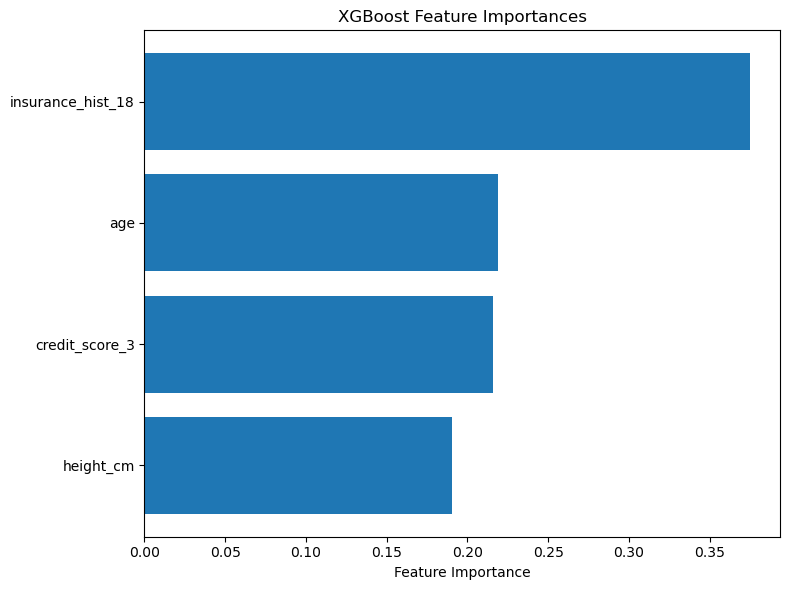

In [71]:
# feature_importances = pipeline_xgb.named_steps['clf'].feature_importances_
feature_importances = calibrated_xgb.base_estimator.steps[1][1].feature_importances_
# features = X.columns.tolist()
features = calibrated_xgb.feature_names_in_

# Create a sorted index for plotting
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(8, 6))
plt.barh([features[i] for i in sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

### SHAP Values

Use SHAP’s KernelExplainer on the entire pipeline to get class-1 probabilities

  0%|          | 0/200 [00:00<?, ?it/s]

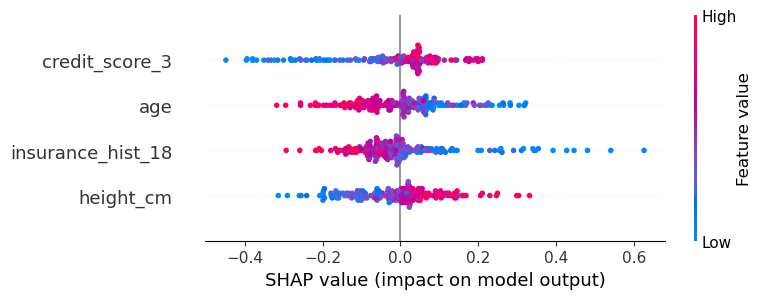

In [72]:
# Define a function that takes a 2D numpy array (or DataFrame values) and returns P(y=1) for each row.
def predict_proba_class1(X_array):
    # Reconstruct a DataFrame from the numpy array so the pipeline sees proper column names
    df_input = pd.DataFrame(X_array, columns=X_train.columns)
    return pipeline_xgb.predict_proba(df_input)[:, 1]

# Choose a small background sample (e.g. 100 rows) from the training set
background = X_train.sample(100, random_state=0)

# Instantiate the KernelExplainer
explainer = shap.KernelExplainer(predict_proba_class1, background)

# Compute SHAP values on a subset of test rows (for speed)
X_subset = X_test.iloc[:200]
shap_values = explainer.shap_values(X_subset, nsamples=200)
# shap_values = explainer.shap_values(X_test, nsamples=len(X_test))

# Summary plot
shap.summary_plot(shap_values, X_subset)

If we need very precise attributions (e.g. for regulatory reasons), bump it up to maybe 500–1,000 rows or more and budget the extra compute time.

# Productionising

## From Notebook to Production Service

1. **Finalise Model**

   * Refactor code into modular, well-documented functions or classes including extracting the data-synthesis, preprocessing and inferencing.
   * Add automated tests (unit + integration) for each step: data ingestion, transformation, model inference.

2. **Containerise the Environment**

   * Create a `Dockerfile` that installs exactly the Python packages and OS dependencies needed.

3. **Wrap Model as an API**

   * Build an API endpoints like `/predict-risk`.
   * The service should accept a JSON payload of customer features, apply preprocessing, and return:

     ```json
     { "risk_score": 0.237, "risk_category": "Low", "explanations": {...} }
     ```

4. **Model History**

   * Serialize the trained model and preprocessing pipeline (e.g. with `joblib` or `MLflow`).
   * Store artifacts in version-controlled storage (MLflow Model Registry).
   * Tag each build.

5. **CI/CD & Automated Testing**

   * Set up continuous integration (GitHub Actions, Jenkins, etc.) to:

6. **Deployment & Infrastructure**

   * Work with DevOps to deploy the container.

7. **Monitoring**

   * Instrument the service for:

     * **Performance metrics:** latency, throughput, error rates.
     * **Business metrics:** aggregate predicted risk distribution, volume of predictions.


## Business-Readiness Considerations

* **API Throughput**: What’s the expected request volume? Ensure the service can handle peak loads.
* **Security**: Any data compliance issues that need to be considered?
* **Explainability**: Package SHAP summaries so underwriters can see “why” a given score was obtained.
* **Integration**: How will this feed into existing policy-pricing systems?
* **Rollback**: If the model service is down, what alternative is performed?

## Stakeholder Handoff and Communication

1. They would be included throughout the build process to ensure the development aligns to their requirements.
2. Upon initial sign-off that the business likes the model, we'd walk the product and engineering teams through the API endpoints, sample responses, and how to embed calls.
3. We'd then move onto User-Acceptance Testing (UAT), where underwriters or pricing teams try to validate that the risk outputs are intuitive and match domain expectations.
4. We'd then provide training and documentation summarise performance, limitations, and intended use.
5. **Final Sign-off**: Secure formal approval from actuaries, legal/compliance, and business owners.

## Cross-Functional Teams to Engage

* **Data Engineering**: Production data pipelines and feature store.
* **DevOps**: Container orchestration, service reliability and monitoring.
* **Underwriting**: Define business rules, acceptance thresholds, and reporting requirements.
* **Actuarial**: Validate model assumptions, pricing logic alignment and regulatory compliance.
* **Security/Legal**: Data privacy impact assessment, encryption and audit trails.

### In-Scope vs. Out-of-Scope

| **In Scope**                                        | **Out of Scope**                                     |
| --------------------------------------------------- | ---------------------------------------------------- |
| • Model development, evaluation, and calibration.   | • Long-term SLAs and infrastructure budgets.         |
| • Dockerising, unit tests, basic CI.                | • Cost-optimization of service.                      |
| • Drafting API spec and demoing to product teams.   | • Enterprise security.                               |
| • Pre-production staging.                           | • Ongoing DevOps resource.                           |
| • Documentation (notebook, model card, user guide). |                                                      |